In [15]:
import os
import numpy as np
import h5py
import matplotlib.pyplot as plt

from scipy.signal import butter, filtfilt
from scipy import sparse
from scipy.sparse.linalg import spsolve

try:
    from sklearn.linear_model import Lasso
except Exception:
    Lasso = None
from pybaselines import Baseline
plt.rcParams["figure.figsize"] = (14, 4)
plt.rcParams["axes.grid"] = True


In [16]:
from scipy.signal import butter, filtfilt, decimate
def list_doric_channels(path):
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]
        chans = []
        if "LockInAOUT02" in base:
            for k in base["LockInAOUT02"].keys():
                if k.startswith("AIN"):
                    chans.append(k)
        chans = sorted(chans)

        digital = []
        if "DigitalIO" in base:
            for k in base["DigitalIO"].keys():
                if k.startswith("DIO"):
                    digital.append(k)
        return chans, digital

def load_doric(path, channel="AIN01", signal_folder="LockInAOUT02", ref_folder="LockInAOUT01",
              trigger_name=None):
    """
    Returns dict with:
      time, sig465, ref405, fs, (optional) trig_time, trig
    """
    with h5py.File(path, "r") as f:
        base = f["DataAcquisition"]["FPConsole"]["Signals"]["Series0001"]

        sig = np.asarray(base[signal_folder][channel][()], float)
        ref = np.asarray(base[ref_folder][channel][()], float)

        # time: prefer the matching folder time if size matches
        t_sig = np.asarray(base[signal_folder]["Time"][()], float) if "Time" in base[signal_folder] else np.array([])
        t_ref = np.asarray(base[ref_folder]["Time"][()], float) if "Time" in base[ref_folder] else np.array([])

        if t_sig.size == sig.size:
            t = t_sig
        elif t_ref.size == sig.size:
            t = t_ref
        else:
            # fallback
            dt = np.nanmedian(np.diff(t_sig)) if t_sig.size > 2 else 1/1000
            t = np.arange(sig.size) * dt

        # if ref length differs, interpolate onto t if possible
        if ref.size != sig.size:
            if t_ref.size == ref.size:
                ref = np.interp(t, t_ref, ref)
            else:
                ref = np.resize(ref, sig.size)

        # sampling rate
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan

        # optional digital trigger overlay
        trig_time = None
        trig = None
        if trigger_name:
            if "DigitalIO" in base and trigger_name in base["DigitalIO"]:
                dio = base["DigitalIO"]
                trig = np.asarray(dio[trigger_name][()], float)
                trig_time = np.asarray(dio["Time"][()], float) if "Time" in dio else None

                # if lengths mismatch, interpolate signals to trigger time (like your Doric logic)
                if trig_time is not None and trig_time.size and trig_time.size != t.size:
                    sig = np.interp(trig_time, t, sig)
                    ref = np.interp(trig_time, t, ref)
                    t = trig_time
                    fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else fs

    out = {"time": t, "sig465": sig, "ref405": ref, "fs": fs}
    if trig is not None and trig_time is not None:
        out["trig_time"] = trig_time
        out["trig"] = trig
    return out
import numpy as np
import numpy as np

def _nan_interp_1d(y: np.ndarray) -> np.ndarray:
    """
    Linearly interpolate NaNs in a 1D array.
    Edge NaNs are filled with nearest valid value.
    """
    y = np.asarray(y, float).copy()
    n = y.size
    if n == 0:
        return y

    isnan = ~np.isfinite(y)
    if not np.any(isnan):
        return y

    x = np.arange(n)
    good = np.isfinite(y)
    if np.sum(good) == 0:
        # nothing to interpolate from
        return y

    y[isnan] = np.interp(x[isnan], x[good], y[good])
    return y


def adaptive_mad_artifact_mask(
    y: np.ndarray,
    fs: float,
    *,
    k: float = 6.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    use_derivative: bool = True,
    min_mad: float = 1e-12,
) -> np.ndarray:
    """
    Build an artifact mask using Adaptive MAD (windowed).

    Detection is performed on dx=diff(y) if use_derivative=True, else directly on y.
    Within each non-overlapping window, compute median and MAD, then flag samples where:
        |x - median| > k * MAD

    Mask is returned at signal sample resolution (len(y)).
    """
    y = np.asarray(y, float)
    n = y.size
    if n == 0:
        return np.zeros((0,), dtype=bool)

    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"adaptive_mad_artifact_mask: invalid fs={fs}")

    x = np.diff(y) if use_derivative else y.copy()
    # x length is n-1 if derivative else n
    nx = x.size
    if nx == 0:
        return np.zeros((n,), dtype=bool)

    win = int(round(window_s * fs))
    win = max(5, win)  # avoid tiny windows

    flagged_x = np.zeros((nx,), dtype=bool)

    # Process non-overlapping windows (fast, “adaptive” across time)
    for start in range(0, nx, win):
        stop = min(start + win, nx)
        seg = x[start:stop]

        # Ignore non-finite values in stats
        seg_f = seg[np.isfinite(seg)]
        if seg_f.size < 5:
            continue

        med = np.median(seg_f)
        mad = np.median(np.abs(seg_f - med))
        mad = max(float(mad), float(min_mad))

        flagged_x[start:stop] = np.abs(seg - med) > (k * mad)

    # Map flagged_x back to signal sample mask (len(y))
    mask = np.zeros((n,), dtype=bool)
    if use_derivative:
        # A large dx affects both samples around the step
        hit = np.where(flagged_x)[0]
        mask[hit] = True
        mask[hit + 1] = True
    else:
        mask[:nx] = flagged_x  # nx == n in this mode

    # Pad mask by pad_s seconds
    pad_n = int(round(pad_s * fs))
    if pad_n > 0 and np.any(mask):
        kernel = np.ones((2 * pad_n + 1,), dtype=int)
        mask = (np.convolve(mask.astype(int), kernel, mode="same") > 0)

    return mask


def remove_artifacts_adaptive_mad(
    time: np.ndarray,
    sig465: np.ndarray,
    ref405: np.ndarray,
    fs: float = None,
    *,
    k: float = 6.0,
    window_s: float = 1.0,
    pad_s: float = 0.2,
    union_channels: bool = True,
    use_derivative: bool = True,
) -> dict:
    """
    Detect + remove artifacts using adaptive MAD (windowed) with padding.

    By default, artifacts are detected on BOTH channels and unioned (recommended),
    then removed from BOTH channels consistently.

    Returns a dict:
      {
        "time": time,
        "sig465_clean": ...,
        "ref405_clean": ...,
        "artifact_mask": ...,
        "artifact_regions_s": [(t0,t1), ...]
      }
    """
    t = np.asarray(time, float)
    s = np.asarray(sig465, float)
    r = np.asarray(ref405, float)

    n = min(t.size, s.size, r.size)
    t, s, r = t[:n], s[:n], r[:n]

    if fs is None:
        fs = 1.0 / float(np.nanmedian(np.diff(t))) if t.size > 2 else np.nan
    if not np.isfinite(fs) or fs <= 0:
        raise ValueError(f"remove_artifacts_adaptive_mad: invalid fs={fs}")

    m_s = adaptive_mad_artifact_mask(s, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative)
    m_r = adaptive_mad_artifact_mask(r, fs, k=k, window_s=window_s, pad_s=pad_s, use_derivative=use_derivative)

    mask = (m_s | m_r) if union_channels else m_s

    s_clean = s.copy()
    r_clean = r.copy()
    s_clean[mask] = np.nan
    r_clean[mask] = np.nan

    s_clean = _nan_interp_1d(s_clean)
    r_clean = _nan_interp_1d(r_clean)

    # Build contiguous regions in seconds (useful for reporting / exporting)
    regions = []
    if np.any(mask):
        idx = np.where(mask)[0]
        # segment mask into contiguous runs
        breaks = np.where(np.diff(idx) > 1)[0]
        starts = np.r_[idx[0], idx[breaks + 1]]
        ends   = np.r_[idx[breaks], idx[-1]]
        for a, b in zip(starts, ends):
            regions.append((float(t[a]), float(t[b])))

    return {
        "time": t,
        "sig465_clean": s_clean,
        "ref405_clean": r_clean,
        "artifact_mask": mask,
        "artifact_regions_s": regions,
        "fs": fs,
    }

def ols_fit(x, y):
    x = np.asarray(x, float)
    y = np.asarray(y, float)
    m = np.isfinite(x) & np.isfinite(y)
    if np.sum(m) < 10:
        return 1.0, 0.0
    X = np.vstack([x[m], np.ones(np.sum(m))]).T
    coef, *_ = np.linalg.lstsq(X, y[m], rcond=None)
    return float(coef[0]), float(coef[1])
def preprocess_signal(sig, fs_raw, target_fs=100, lpf_cutoff=3):
    """
    1\) Low-pass filter (Butterworth, lpf_cutoff Hz)
    2\) Decimate to target sampling rate (target_fs Hz)
    """
    nyquist = 0.5 * fs_raw
    normal_cutoff = lpf_cutoff / nyquist
    b, a = butter(N=2, Wn=normal_cutoff, btype="low", analog=False)
    sig_filtered = filtfilt(b, a, sig)

    q = int(fs_raw / target_fs)
    if q > 1:
        sig_downsampled = decimate(sig_filtered, q)
        real_fs = fs_raw / q
    else:
        sig_downsampled = sig_filtered
        real_fs = fs_raw

    return sig_downsampled, real_fs


def compute_arpls_baselines(
    baseline_fitter,
    sig_f,
    ref_f,
    lam=1e9,
    diff_order=2,
    max_iter=50,
    tol=1e-3,
):
    """
    Compute arPLS baselines for signal and reference.

    Parameters:
        baseline_fitter: pybaselines.Baseline instance, already set up with x_data.
        sig_f: 1D array-like, preprocessed signal channel.
        ref_f: 1D array-like, preprocessed reference channel.
        lam: smoothing parameter.
        diff_order: difference order for the penalty.
        max_iter: maximum iterations for arPLS.
        tol: convergence tolerance.

    Returns:
        b_sig_arpls, b_ref_arpls
    """
    b_sig_arpls, _ = baseline_fitter.arpls(
        sig_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    b_ref_arpls, _ = baseline_fitter.arpls(
        ref_f, lam=lam, diff_order=diff_order,
        max_iter=max_iter, tol=tol
    )
    return b_sig_arpls, b_ref_arpls




import numpy as np
import statsmodels.api as sm

def compute_motion_corrected_dff_robust(sig_f, ref_f, b_sig, b_ref):
    """
    Computes motion-corrected dF/F using dF/F-first strategy and Robust Regression.
    """
    # --- 1. Calculate raw dF/F for each channel ---
    # Safe division
    den_sig = np.asarray(b_sig, float).copy()
    den_sig[np.abs(den_sig) < 1e-12] = np.nan
    dff_sig_raw = (sig_f - b_sig) / den_sig

    den_ref = np.asarray(b_ref, float).copy()
    den_ref[np.abs(den_ref) < 1e-12] = np.nan
    dff_ref_raw = (ref_f - b_ref) / den_ref

    # Handle NaNs created by division (optional but recommended)
    valid_mask = ~np.isnan(dff_sig_raw) & ~np.isnan(dff_ref_raw)

    # --- 2. Fit Reference to Signal using Robust Linear Model (IRLS) ---
    # Prepare data for statsmodels (needs constant for intercept)
    X = dff_ref_raw[valid_mask]
    Y = dff_sig_raw[valid_mask]
    X_const = sm.add_constant(X)

    # RLM with HuberT weighting reduces impact of calcium spikes
    model = sm.RLM(Y, X_const, M=sm.robust.norms.HuberT())
    results = model.fit()

    b_fit, a_fit = results.params  # Intercept (b), Slope (a)

    # --- 3. Subtract Fitted Reference ---
    # fitted_ref = slope * ref + intercept
    fitted_ref = a_fit * dff_ref_raw + b_fit
    dff_mc = dff_sig_raw - fitted_ref

    return {
        "sig_det": dff_sig_raw,
        "ref_det": dff_ref_raw,
        "a": a_fit,
        "b": b_fit,
        "dff": dff_mc
    }

def list_doric_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".doric"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files
def list_labels_files(folder_path):
    """
    Return a list of full paths to all .doric files in the given folder.
    """
    doric_files = []
    for fname in os.listdir(folder_path):
        if fname.lower().endswith(".csv"):
            doric_files.append(os.path.join(folder_path, fname))
    return doric_files
import numpy as np
import matplotlib.pyplot as plt

def qc_sig_ref_correlation(sig, ref, title="", max_points=8000, ax=None):
    """
    Scatter sig vs ref with OLS fit + Pearson R, R^2.
    Downsamples points for plotting but computes stats on full data.
    Returns dict with r, r2, slope, intercept, n.
    """
    sig = np.asarray(sig, float)
    ref = np.asarray(ref, float)

    m = np.isfinite(sig) & np.isfinite(ref)
    sig = sig[m]
    ref = ref[m]
    n = int(sig.size)

    out = {"r": np.nan, "r2": np.nan, "slope": np.nan, "intercept": np.nan, "n": n}

    if n < 10:
        return out

    # Pearson R
    s0 = sig - np.mean(sig)
    r0 = ref - np.mean(ref)
    denom = np.sqrt(np.sum(s0**2) * np.sum(r0**2))
    if denom > 0:
        r = float(np.sum(s0 * r0) / denom)
    else:
        r = np.nan
    out["r"] = r
    out["r2"] = float(r**2) if np.isfinite(r) else np.nan

    # OLS fit sig = a*ref + b
    X = np.vstack([ref, np.ones_like(ref)]).T
    coef, *_ = np.linalg.lstsq(X, sig, rcond=None)
    a, b = float(coef[0]), float(coef[1])
    out["slope"] = a
    out["intercept"] = b

    # Plot
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.2, 3.6))

    # downsample points for display
    if n > max_points:
        idx = np.random.default_rng(0).choice(n, size=max_points, replace=False)
        xs = ref[idx]
        ys = sig[idx]
    else:
        xs, ys = ref, sig

    ax.scatter(xs, ys, s=6, alpha=0.25, edgecolors="none")

    # fit line over displayed x-range
    xlo, xhi = np.nanpercentile(ref, [1, 99])
    xx = np.linspace(xlo, xhi, 200)
    yy = a * xx + b
    ax.plot(xx, yy, lw=1.8)

    ax.set_title(title, fontsize=10)
    ax.set_xlabel("Reference 405 (a.u.)")
    ax.set_ylabel("Signal 465 (a.u.)")

    # cosmetics
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.grid(True, alpha=0.15)

    ax.text(
        0.02, 0.98,
        f"R = {out['r']:.3f}\nR² = {out['r2']:.3f}\na = {a:.3g}",
        transform=ax.transAxes, va="top", ha="left", fontsize=9
    )

    return out


In [17]:
folder = r'C:\Analysis\fiber_photometry_app\test_data\FI'
doric_paths = list_doric_files(folder)
labels_paths = list_labels_files(folder)
print(doric_paths)
print(labels_paths)

['C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030545_Adu.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030545_Fem.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030545_Juv.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030546_Adu.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030546_Fem.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030546_Juv.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030547_Adu.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030547_Fem.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030547_Juv.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030549_Adu.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030549_Fem.doric', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030549_Juv.doric']
['C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030545_Adu.csv', 'C:\\Analysis\\fiber_photometry_app\\test_data\\FI\\030545_Fem.csv', 'C:\\Ana

Processing: 030545_Adu.doric -> Animal ID: 030545


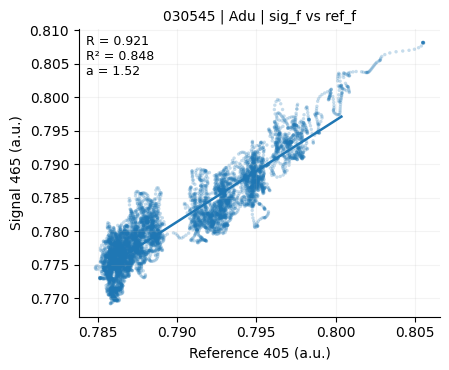

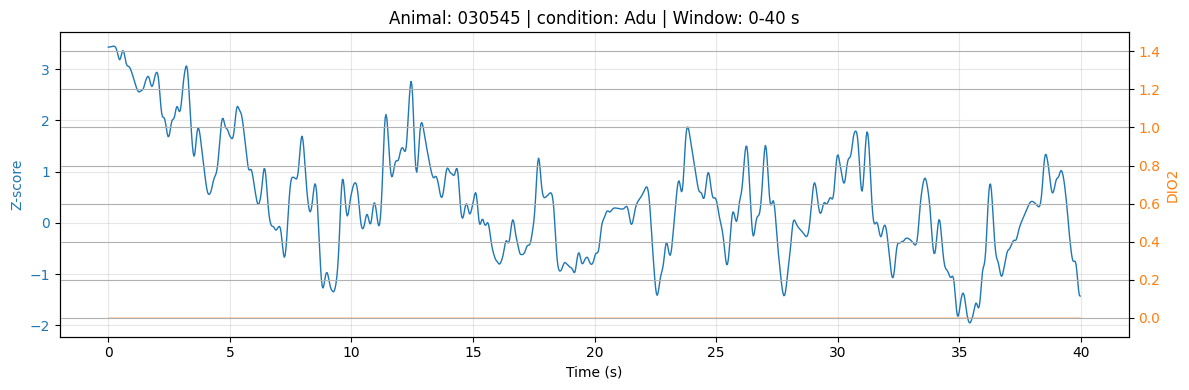

Processing: 030545_Fem.doric -> Animal ID: 030545


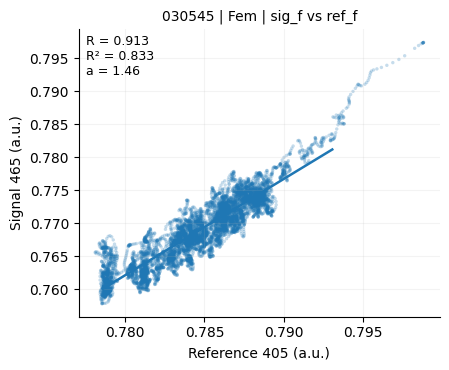

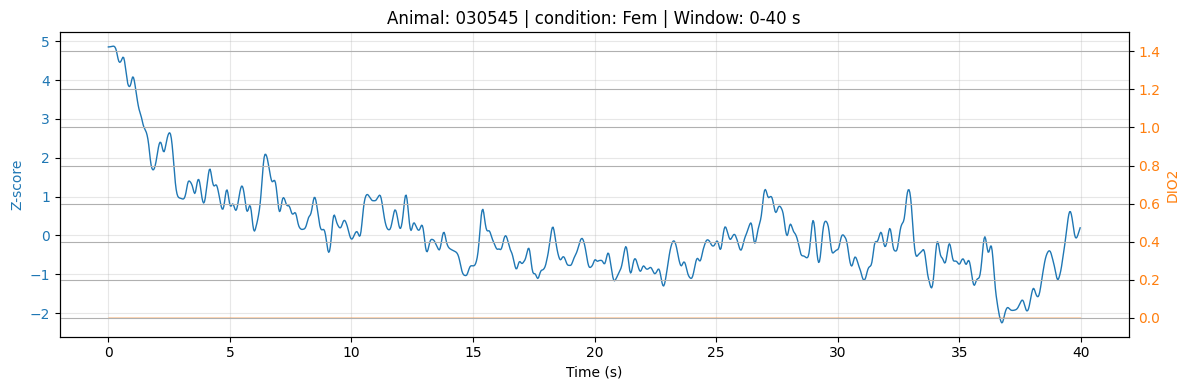

Processing: 030545_Juv.doric -> Animal ID: 030545


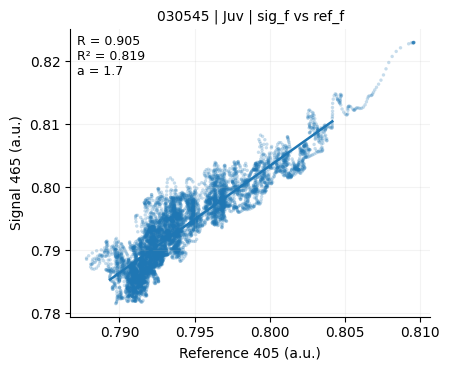

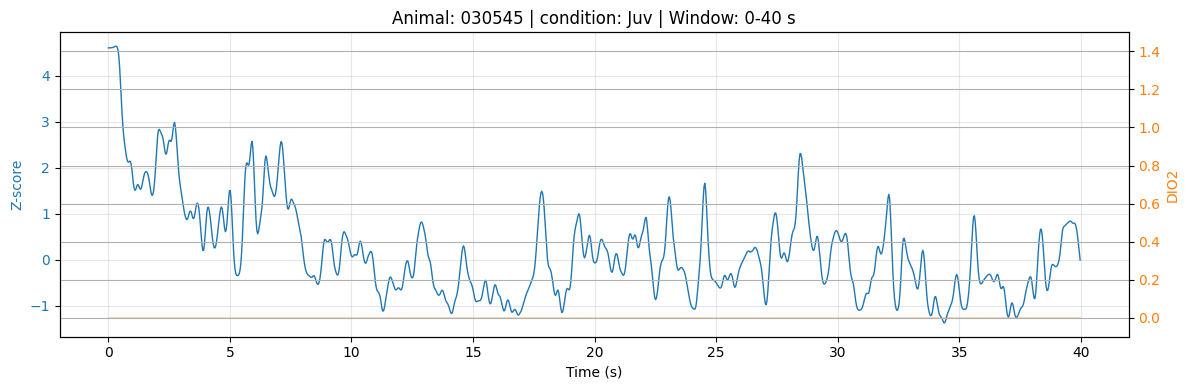

Processing: 030546_Adu.doric -> Animal ID: 030546


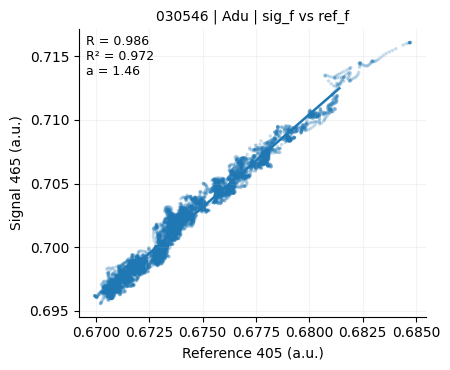

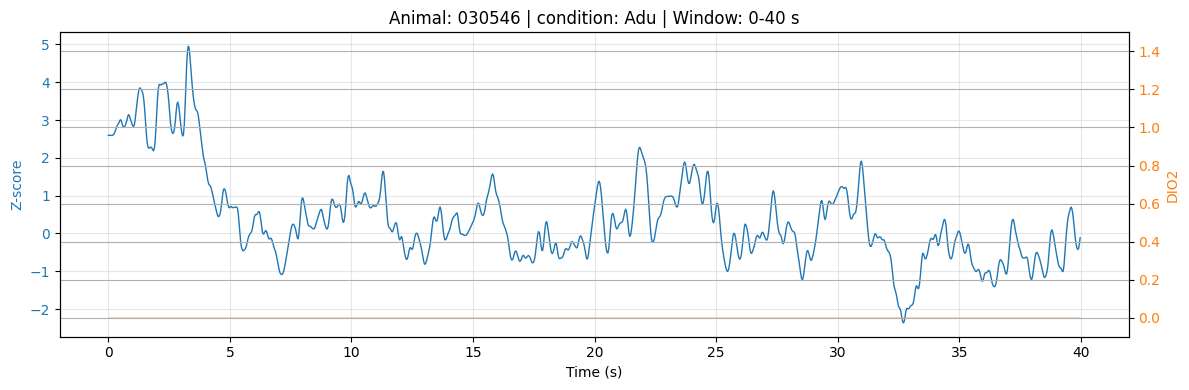

Processing: 030546_Fem.doric -> Animal ID: 030546


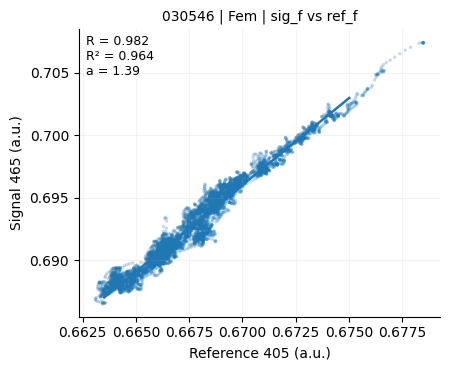

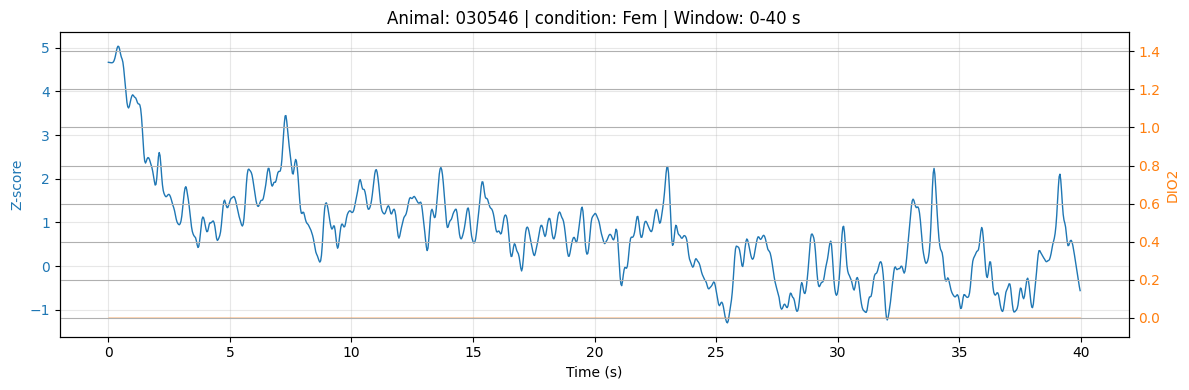

Processing: 030546_Juv.doric -> Animal ID: 030546


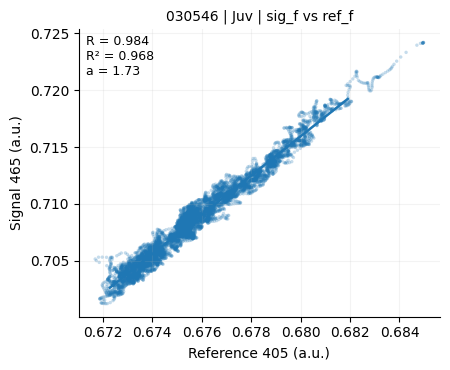

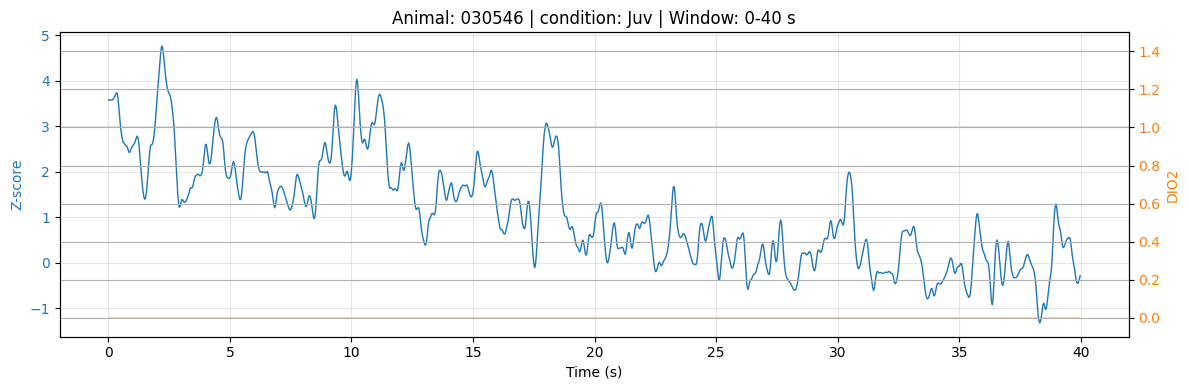

Processing: 030547_Adu.doric -> Animal ID: 030547


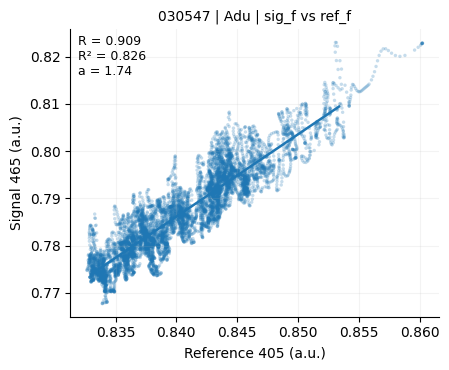

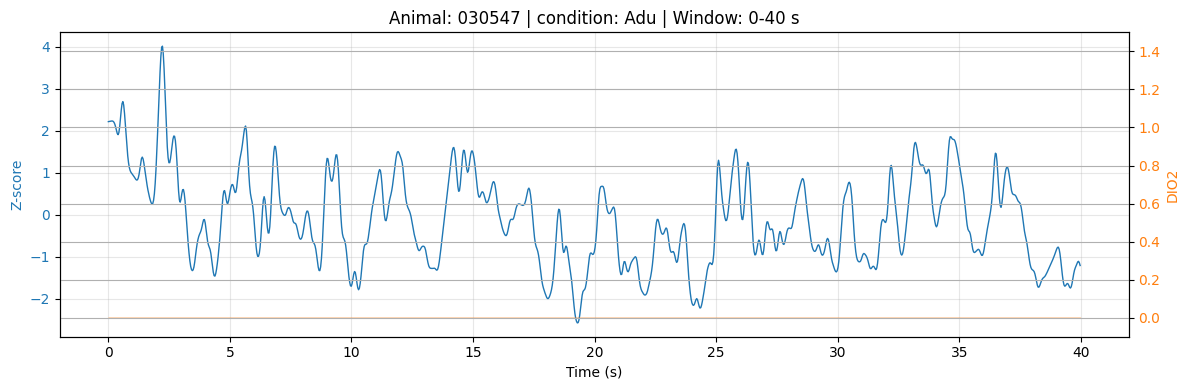

Processing: 030547_Fem.doric -> Animal ID: 030547


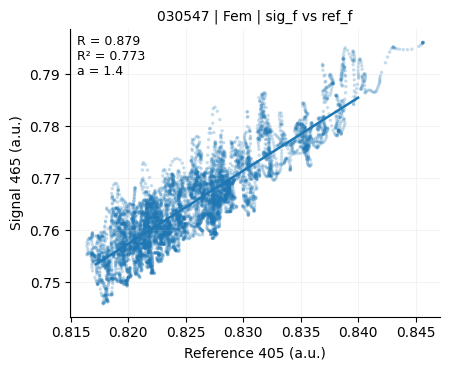

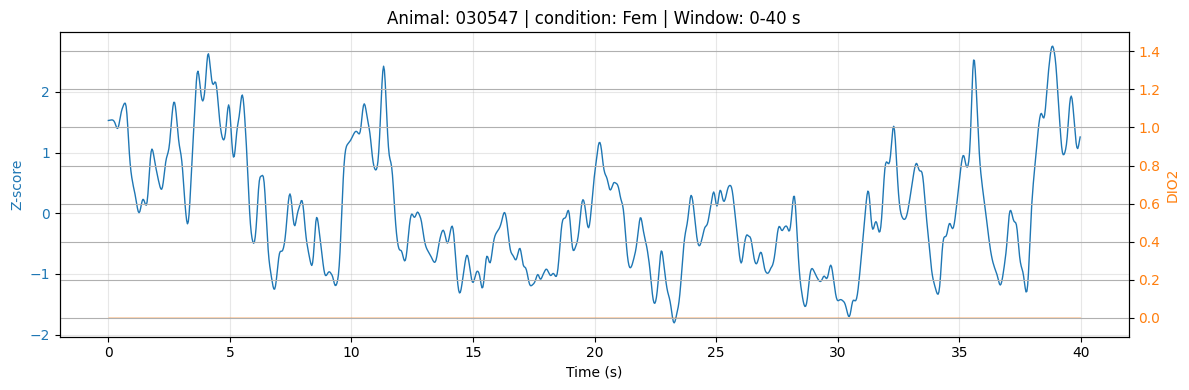

Processing: 030547_Juv.doric -> Animal ID: 030547


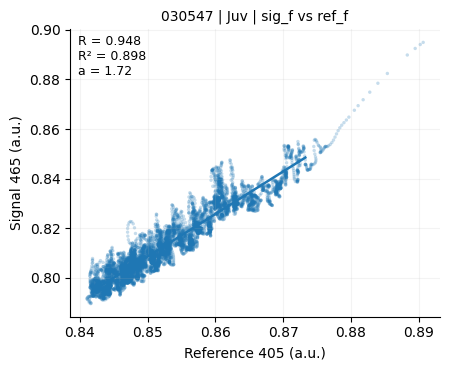

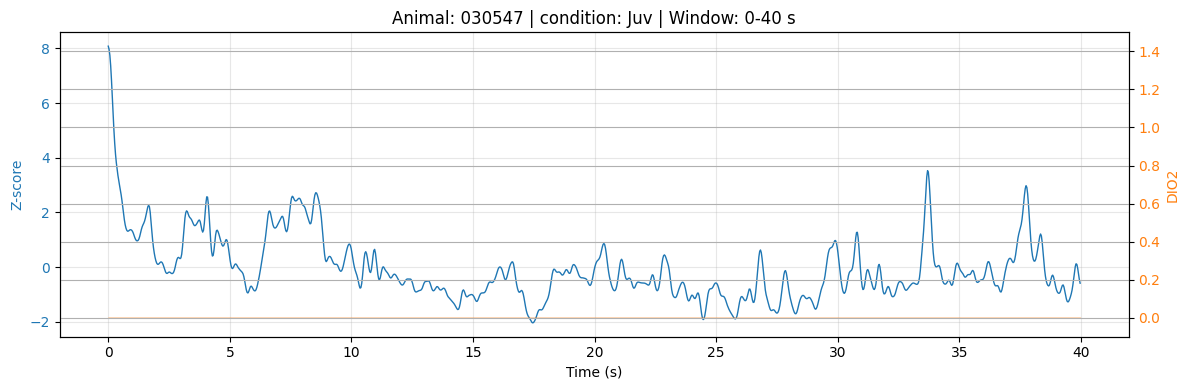

Processing: 030549_Adu.doric -> Animal ID: 030549


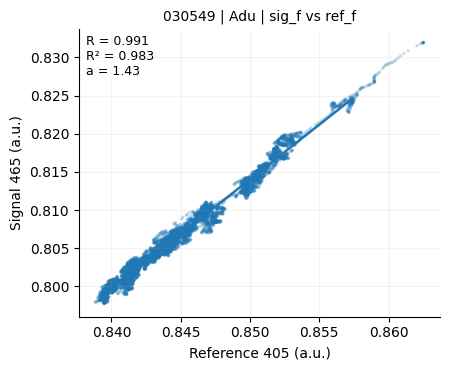

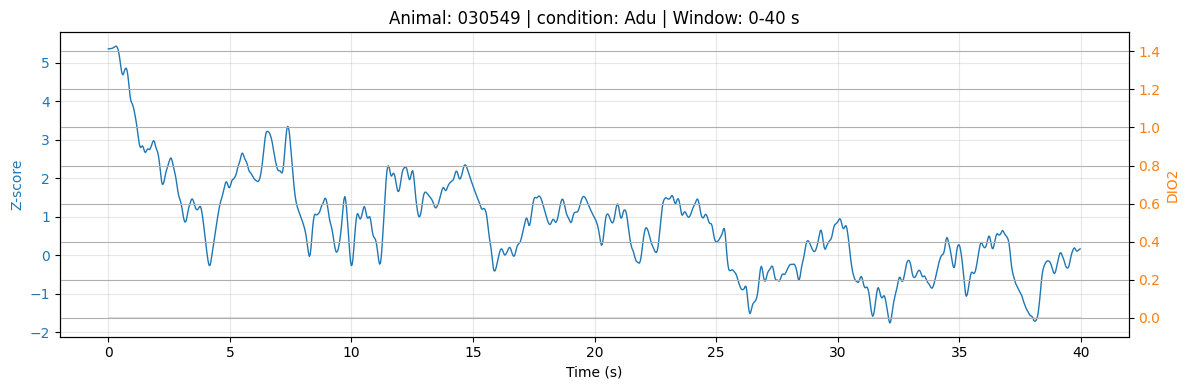

Processing: 030549_Fem.doric -> Animal ID: 030549


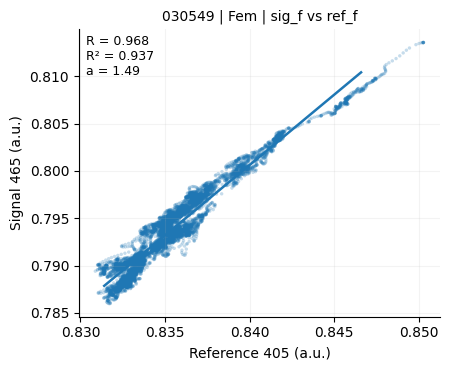

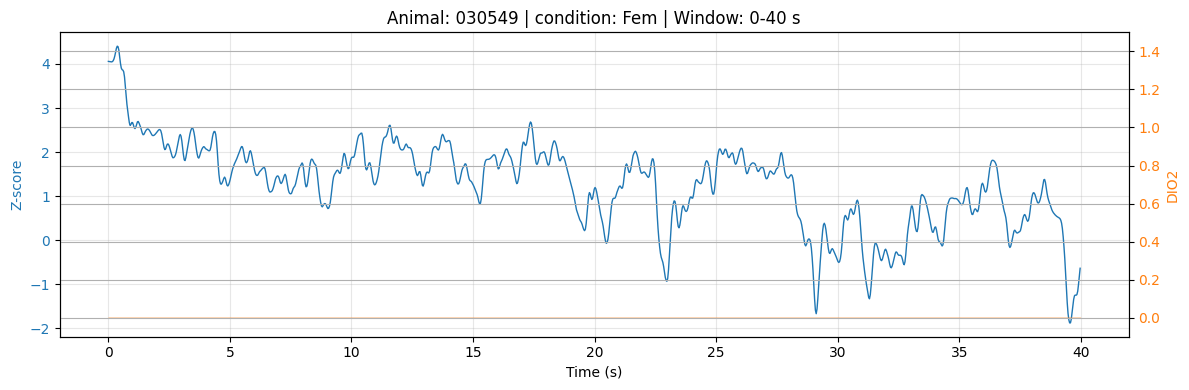

Processing: 030549_Juv.doric -> Animal ID: 030549


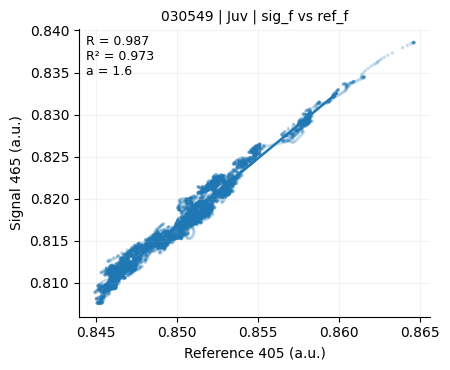

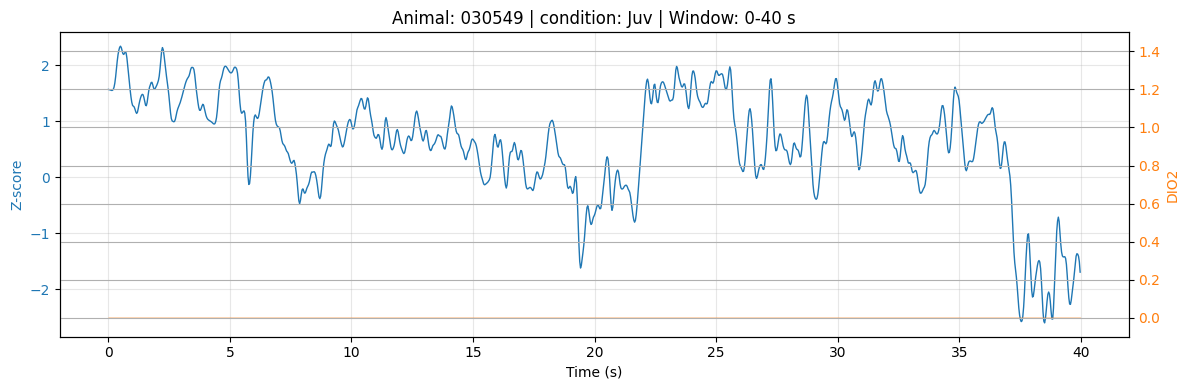

In [18]:


# Parameters
target_fs = 30
lpf_cutoff = 3
lam = 1e12
diff_order = 2
max_iter = 50
tol = 1e-3

# --- Artifact removal parameters (Adaptive MAD windowed) ---
art_k = 6.0
art_window_s = 1.0
art_pad_s = 0.2
art_union_channels = True      # detect on both channels and union mask (recommended)
art_use_derivative = False      # detect on dx (recommended)

# ---- user option: plot only a specific time window (seconds) ----
plot_window = [0, 40]  # e.g., [start_s, end_s]
# plot_window = None

def apply_plot_window(t: np.ndarray, *series: np.ndarray, plot_window=None):
    if plot_window is None:
        mask = np.ones_like(t, dtype=bool)
        return (t, *series, mask)

    lo, hi = float(plot_window[0]), float(plot_window[1])
    if lo > hi:
        lo, hi = hi, lo

    mask = (t >= lo) & (t <= hi)
    t2 = t[mask]
    series2 = [s[mask] if s is not None else None for s in series]
    return (t2, *series2, mask)
result_list=[]
qc_list = []  # will store per-recording QC metrics
for path in doric_paths:
    results = {}
    filename = os.path.basename(path)
    file_name=os.path.splitext(os.path.basename(path))[0]
    animal_id=file_name.split('_')[0]
    condition=file_name.split('_')[1]


    print(f"Processing: {filename} -> Animal ID: {animal_id}")

    rec = load_doric(path, trigger_name="DIO02")

    # Raw signals/time
    t_raw = rec["time"]
    sig_raw = rec["sig465"]
    ref_raw = rec["ref405"]
    fs_raw = rec["fs"]

    dio_raw = rec.get("trig", None)
    dio_time = rec.get("trig_time", None)

    # -------------------- Artifact removal FIRST --------------------
    art = remove_artifacts_adaptive_mad(
        t_raw, sig_raw, ref_raw, fs_raw,
        k=art_k, window_s=art_window_s, pad_s=art_pad_s,
        union_channels=art_union_channels,
        use_derivative=art_use_derivative
    )

    # Use cleaned signals for all subsequent preprocessing
    sig = art["sig465_clean"]
    ref = art["ref405_clean"]
    # (time/fs unchanged, but take from art for consistency)
    t_raw = art["time"]
    fs = art["fs"]

    # -------------------- Continue preprocessing --------------------
    sig_f, fs_sig = preprocess_signal(sig, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)
    ref_f, fs_ref = preprocess_signal(ref, fs, target_fs=target_fs, lpf_cutoff=lpf_cutoff)

 # ---- QC: correlation scatter + fit ----
    qc_title = f"{animal_id} | {condition} | sig_f vs ref_f"
    fig_qc, ax_qc = plt.subplots(figsize=(4.6, 3.8))
    qc = qc_sig_ref_correlation(sig_f, ref_f, title=qc_title, ax=ax_qc)
    plt.tight_layout()
    plt.show()

    # store QC metrics
    qc.update({
        "animal": animal_id,
        "condition": condition,
        "file": os.path.basename(path),
        "artifact_fraction": float(np.mean(art["artifact_mask"])) if art["artifact_mask"].size else 0.0,
        "fs_used": float(fs_sig),
        "sig_std": float(np.nanstd(sig_f)),
        "ref_std": float(np.nanstd(ref_f)),
    })
    qc_list.append(qc)

    dt_ds = 1.0 / fs_sig
    t_ds = np.arange(sig_f.size) * dt_ds

    baseline_fitter = Baseline(x_data=t_ds)
    b_sig, b_ref = compute_arpls_baselines(
        baseline_fitter, sig_f, ref_f,
        lam=lam, diff_order=diff_order, max_iter=max_iter, tol=tol
    )

    dff_results = compute_motion_corrected_dff_robust(sig_f, ref_f, b_sig, b_ref)
    dff_mc = dff_results["dff"]

    dff_z = (dff_mc - np.nanmean(dff_mc)) / np.nanstd(dff_mc)

    if dio_raw is not None and dio_time is not None:
        dio_ds = np.interp(t_ds, dio_time, dio_raw)
    else:
        dio_ds = np.zeros_like(t_ds)

    results = {
        'animal': animal_id,
        'condition': condition,
        "t": t_ds,
        "dff": dff_mc,
        "zscore": dff_z,
        "dio2": dio_ds,
        # Optional: keep artifact info for QA/QC
        "artifact_regions_s": art["artifact_regions_s"],
        "artifact_fraction": float(np.mean(art["artifact_mask"])) if art["artifact_mask"].size else 0.0,
    }
    result_list.append(results)
    # ---- apply plot window right before plotting ----
    t_plot, dff_z_plot, dio_plot, _mask = apply_plot_window(
        t_ds, dff_z, dio_ds, plot_window=plot_window
    )

    fig, ax1 = plt.subplots(figsize=(12, 4))

    color_z = "tab:blue"
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Z-score", color=color_z)
    ax1.plot(t_plot, dff_z_plot, color=color_z, lw=1, label="dF/F Z-score")
    ax1.tick_params(axis="y", labelcolor=color_z)
    ax1.grid(True, alpha=0.3)

    ax2 = ax1.twinx()
    color_dio = "tab:orange"
    ax2.set_ylabel("DIO2", color=color_dio)
    ax2.fill_between(t_plot, dio_plot, color=color_dio, alpha=0.3, step="mid", label="DIO2")
    ax2.tick_params(axis="y", labelcolor=color_dio)
    ax2.set_ylim(-0.1, 1.5)

    if plot_window is not None:
        plt.title(f"Animal: {animal_id} | condition: {condition} | Window: {plot_window[0]}-{plot_window[1]} s")
    else:
        plt.title(f"Animal: {animal_id} | File: {filename}")

    plt.tight_layout()
    plt.show()


In [19]:
import os
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d

# Build lookup from your list (recommended)
results_by_key = {(r["animal"], r["condition"]): r for r in result_list}

# -------------------------
# Attach behavior CSVs
# -------------------------
for path in labels_paths:
    behaviors = pd.read_csv(path, delimiter=",")  # delimiter updated

    file_name = os.path.splitext(os.path.basename(path))[0]  # e.g. "M01-Adu"
    parts = file_name.split("_")
    if len(parts) < 2:
        print(f"Skipping {os.path.basename(path)}: expected 'Animal-Cond.csv'")
        continue

    animal_id = parts[0]
    condition = parts[1]
    key = (animal_id, condition)

    if key not in results_by_key:
        print(f"No matching fiber record for {key} from {os.path.basename(path)}")
        continue

    results_by_key[key]["behavior"] = behaviors

# -------------------------
# Align fiber to behavior time
# -------------------------
for (animal_id, condition), rec in results_by_key.items():
    if "behavior" not in rec:
        continue

    fiber_time = np.asarray(rec["t"], float)
    fiber_z = np.asarray(rec["zscore"], float)

    behavior_df = rec["behavior"]
    if "time" not in behavior_df.columns:
        print(f"{animal_id}-{condition}: behavior missing 'time' column; skipping")
        continue

    behavior_time = behavior_df["time"].to_numpy(dtype=float)

    print(f"Aligning {animal_id}-{condition}:")
    print(f"  Fiber range: {fiber_time[0]:.2f}s to {fiber_time[-1]:.2f}s")
    print(f"  Behav range: {behavior_time[0]:.2f}s to {behavior_time[-1]:.2f}s")

    interpolator = interp1d(
        fiber_time, fiber_z,
        kind="linear",
        bounds_error=False,
        fill_value=np.nan
    )

    aligned_fiber = interpolator(behavior_time)
    rec["behavior"]["fiber_zscore_aligned"] = aligned_fiber

    print(f"  New column shape: {rec['behavior']['fiber_zscore_aligned'].shape}")


Aligning 030545-Adu:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.05s
  New column shape: (9002,)
Aligning 030545-Fem:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.01s
  New column shape: (9000,)
Aligning 030545-Juv:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.05s
  New column shape: (9001,)
Aligning 030546-Adu:
  Fiber range: 0.00s to 299.96s
  Behav range: -0.00s to 300.03s
  New column shape: (9001,)
Aligning 030546-Fem:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.02s
  New column shape: (9001,)
Aligning 030546-Juv:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.04s
  New column shape: (9002,)
Aligning 030547-Adu:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.01s
  New column shape: (9001,)
Aligning 030547-Fem:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.03s
  New column shape: (9001,)
Aligning 030547-Juv:
  Fiber range: 0.00s to 300.00s
  Behav range: -0.00s to 300.03s
  

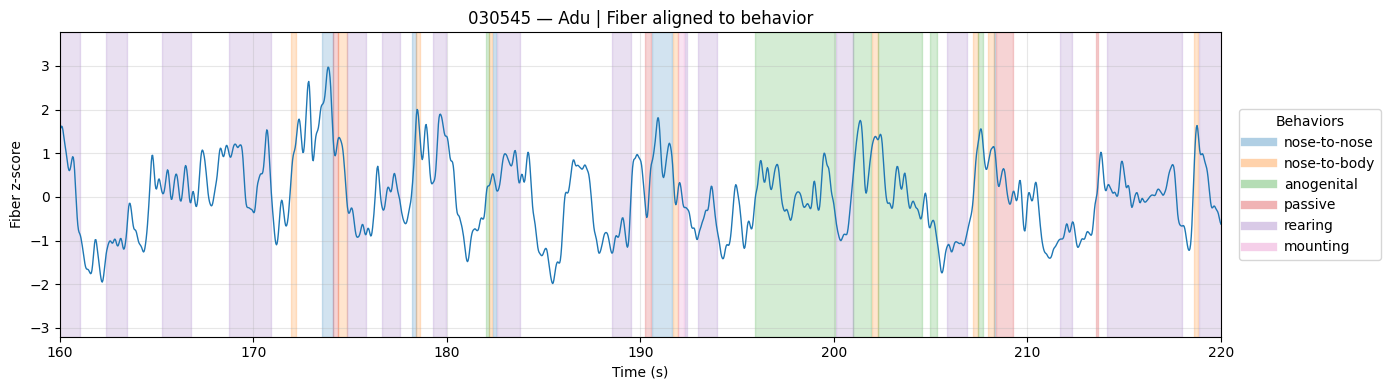

030545-Adu: average bout duration (s)
            anogenital: 0.736  (n_bouts=42)
              mounting: 0.333  (n_bouts=2)
          nose-to-body: 0.381  (n_bouts=45)
          nose-to-nose: 0.431  (n_bouts=20)
               passive: 0.457  (n_bouts=23)
               rearing: 1.129  (n_bouts=69)


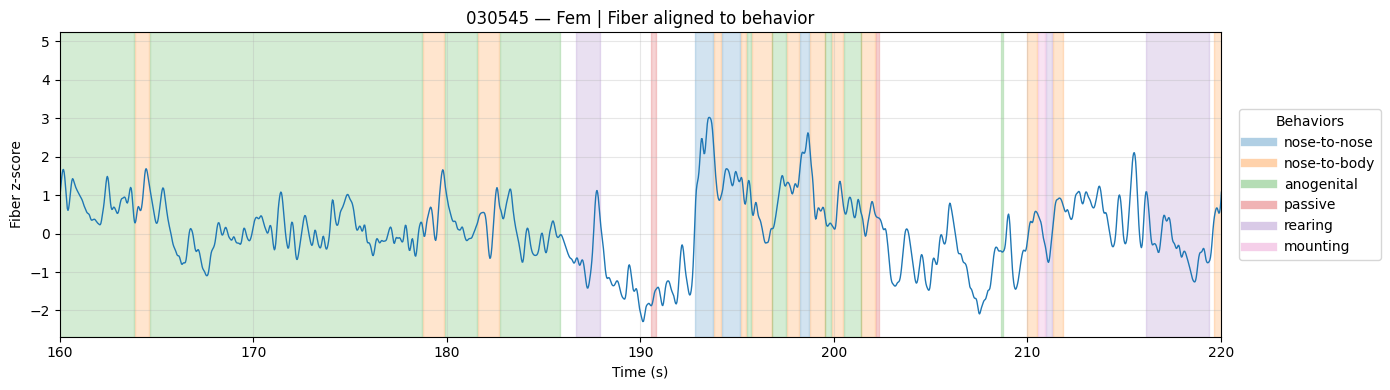

030545-Fem: average bout duration (s)
            anogenital: 2.336  (n_bouts=33)
              mounting: 0.399  (n_bouts=1)
          nose-to-body: 0.616  (n_bouts=57)
          nose-to-nose: 0.701  (n_bouts=28)
               passive: 0.275  (n_bouts=11)
               rearing: 1.440  (n_bouts=26)


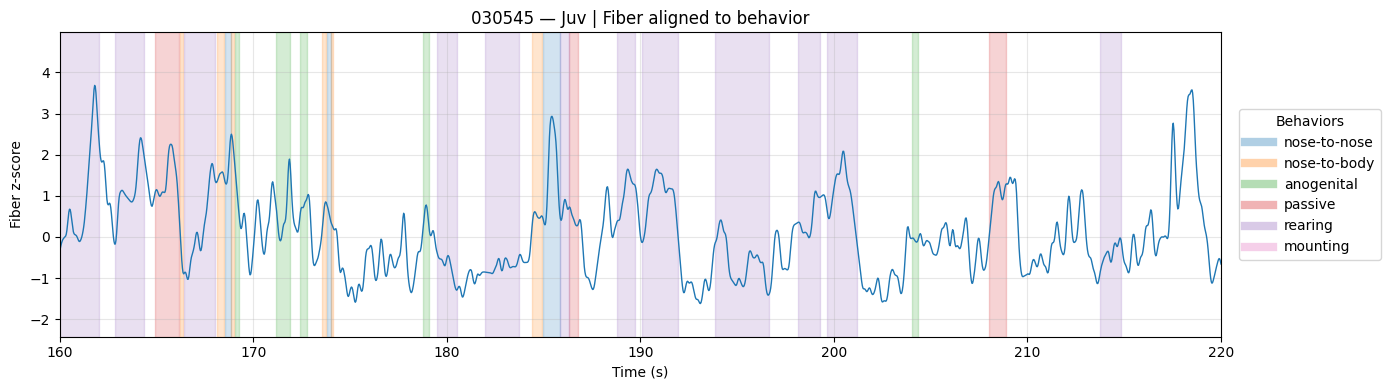

030545-Juv: average bout duration (s)
            anogenital: 0.991  (n_bouts=51)
              mounting: 0.673  (n_bouts=6)
          nose-to-body: 0.518  (n_bouts=53)
          nose-to-nose: 0.478  (n_bouts=22)
               passive: 1.388  (n_bouts=30)
               rearing: 1.308  (n_bouts=34)


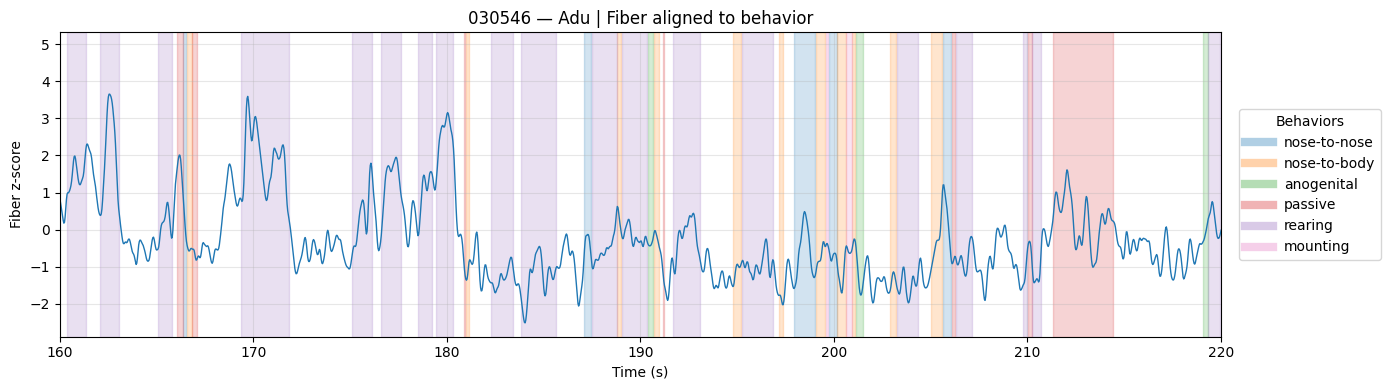

030546-Adu: average bout duration (s)
            anogenital: 0.566  (n_bouts=39)
              mounting: 0.334  (n_bouts=7)
          nose-to-body: 0.343  (n_bouts=41)
          nose-to-nose: 0.451  (n_bouts=17)
               passive: 0.650  (n_bouts=30)
               rearing: 0.964  (n_bouts=76)


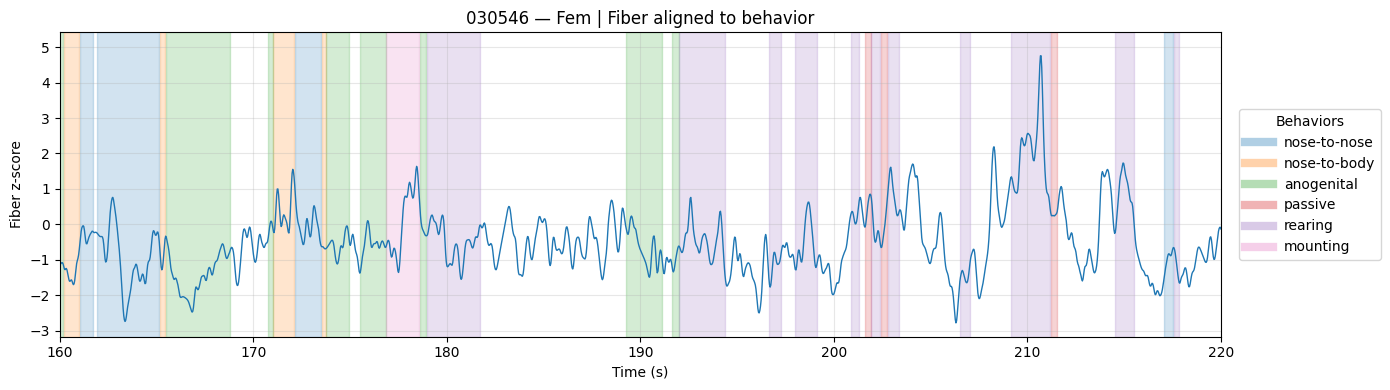

030546-Fem: average bout duration (s)
            anogenital: 1.768  (n_bouts=29)
              mounting: 1.016  (n_bouts=2)
          nose-to-body: 0.367  (n_bouts=17)
          nose-to-nose: 0.722  (n_bouts=9)
               passive: 0.390  (n_bouts=20)
               rearing: 1.256  (n_bouts=41)


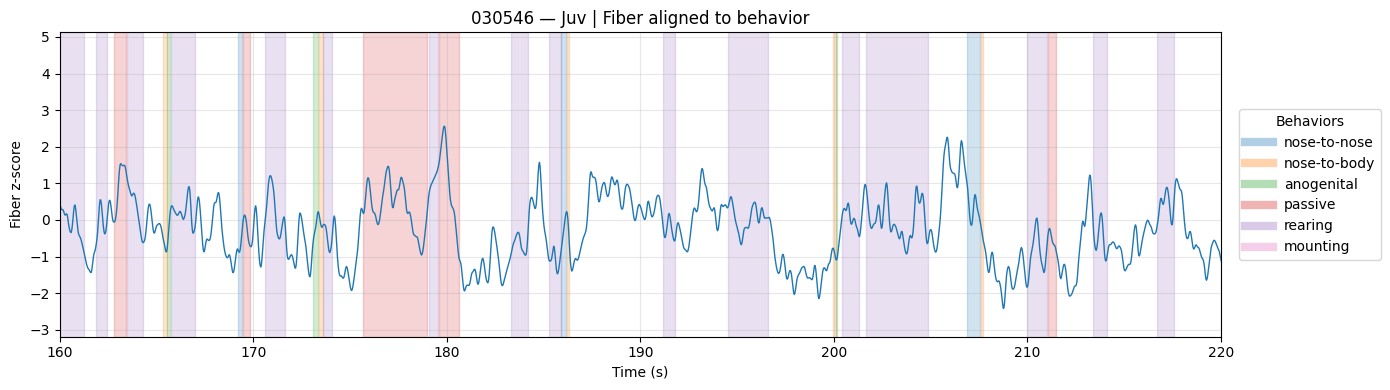

030546-Juv: average bout duration (s)
            anogenital: 0.700  (n_bouts=39)
              mounting: 0.284  (n_bouts=2)
          nose-to-body: 0.418  (n_bouts=30)
          nose-to-nose: 0.484  (n_bouts=18)
               passive: 0.579  (n_bouts=31)
               rearing: 1.198  (n_bouts=53)


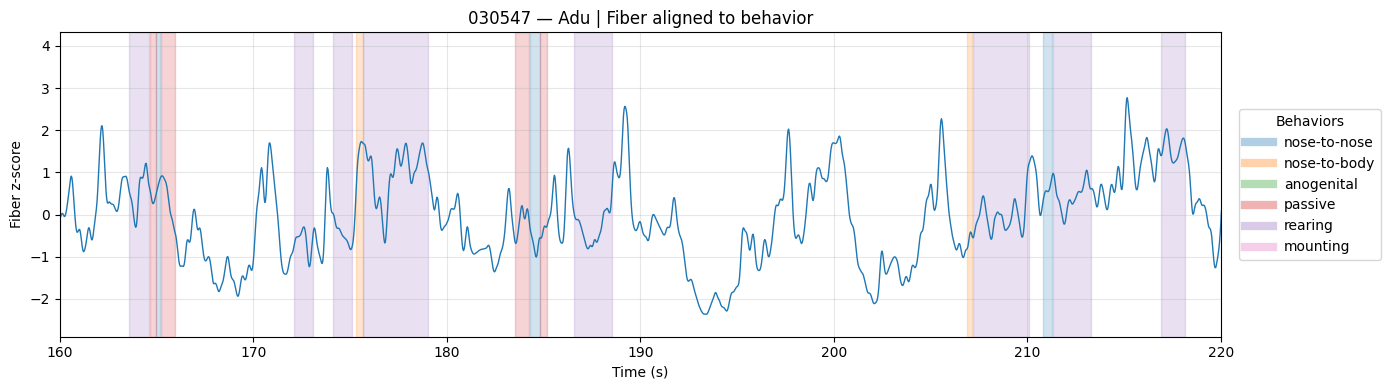

030547-Adu: average bout duration (s)
            anogenital: 0.755  (n_bouts=41)
              mounting: 0.300  (n_bouts=2)
          nose-to-body: 0.372  (n_bouts=46)
          nose-to-nose: 0.320  (n_bouts=22)
               passive: 0.299  (n_bouts=24)
               rearing: 1.333  (n_bouts=49)


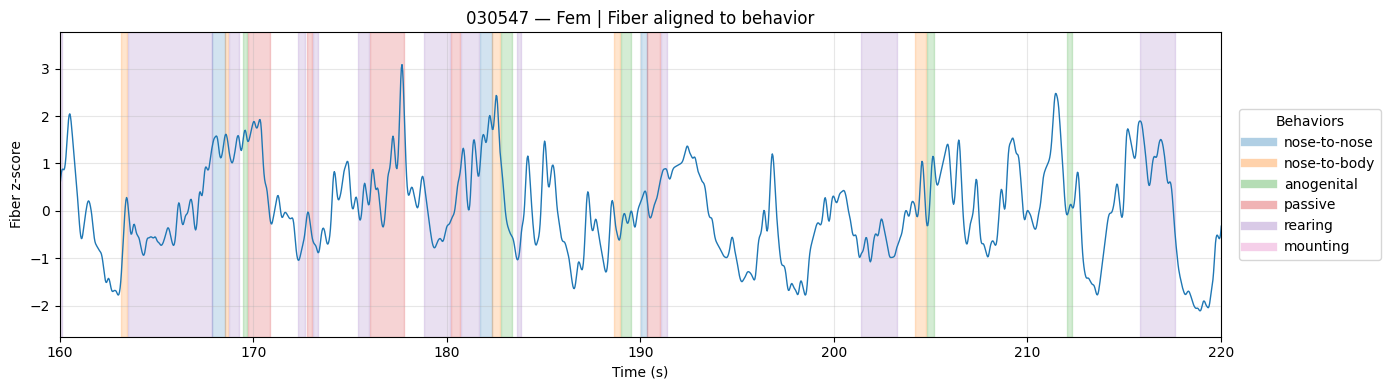

030547-Fem: average bout duration (s)
            anogenital: 0.987  (n_bouts=34)
              mounting: 0.328  (n_bouts=7)
          nose-to-body: 0.435  (n_bouts=31)
          nose-to-nose: 0.350  (n_bouts=23)
               passive: 0.913  (n_bouts=29)
               rearing: 1.297  (n_bouts=44)


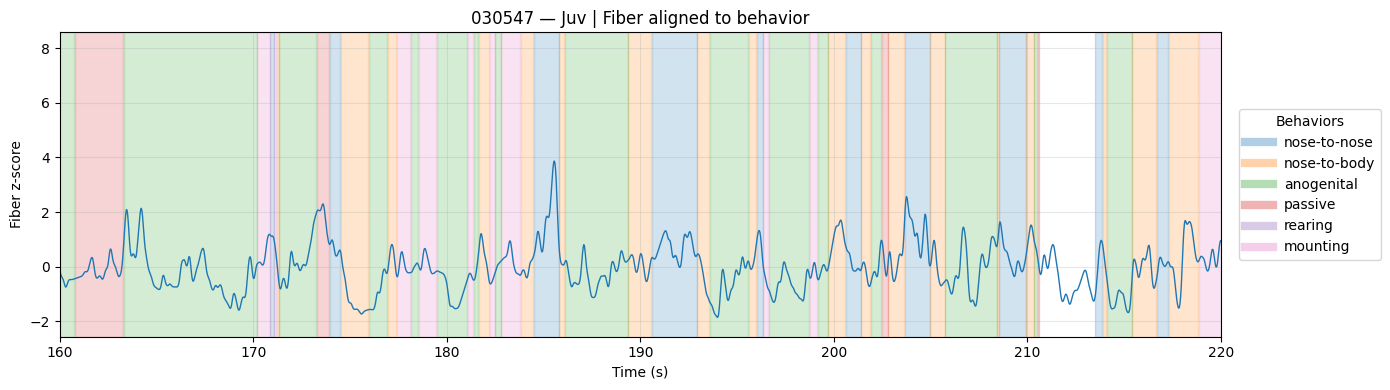

030547-Juv: average bout duration (s)
            anogenital: 1.967  (n_bouts=60)
              mounting: 0.542  (n_bouts=20)
          nose-to-body: 0.628  (n_bouts=65)
          nose-to-nose: 0.696  (n_bouts=35)
               passive: 0.920  (n_bouts=38)
               rearing: 1.434  (n_bouts=6)


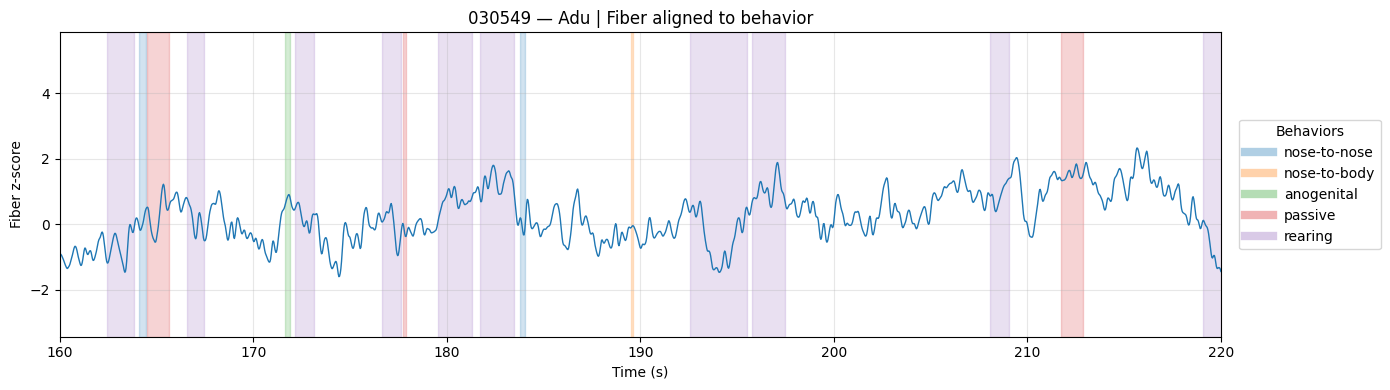

030549-Adu: average bout duration (s)
            anogenital: 0.303  (n_bouts=12)
          nose-to-body: 0.445  (n_bouts=21)
          nose-to-nose: 0.395  (n_bouts=13)
               passive: 0.712  (n_bouts=26)
               rearing: 1.278  (n_bouts=61)


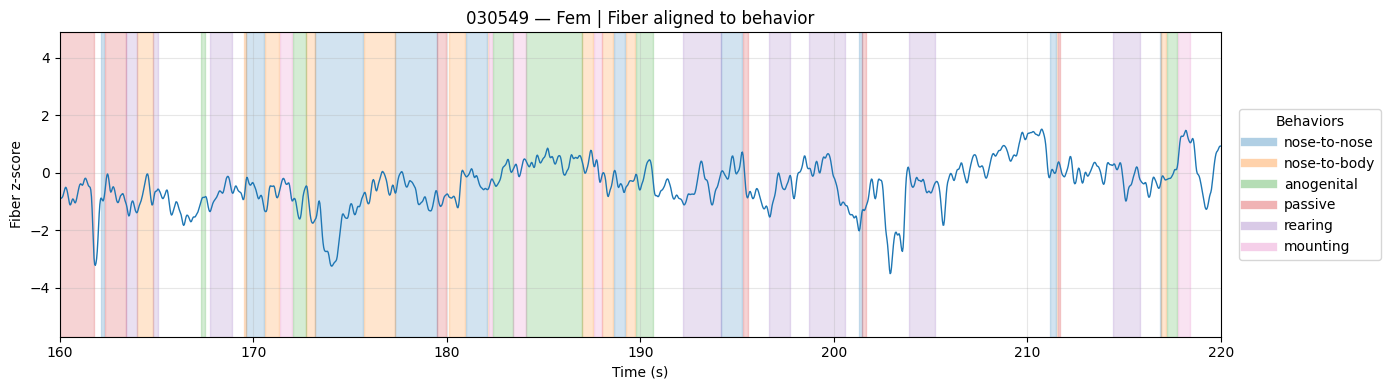

030549-Fem: average bout duration (s)
            anogenital: 1.967  (n_bouts=46)
              mounting: 0.642  (n_bouts=19)
          nose-to-body: 0.421  (n_bouts=46)
          nose-to-nose: 0.847  (n_bouts=27)
               passive: 0.940  (n_bouts=20)
               rearing: 1.424  (n_bouts=25)


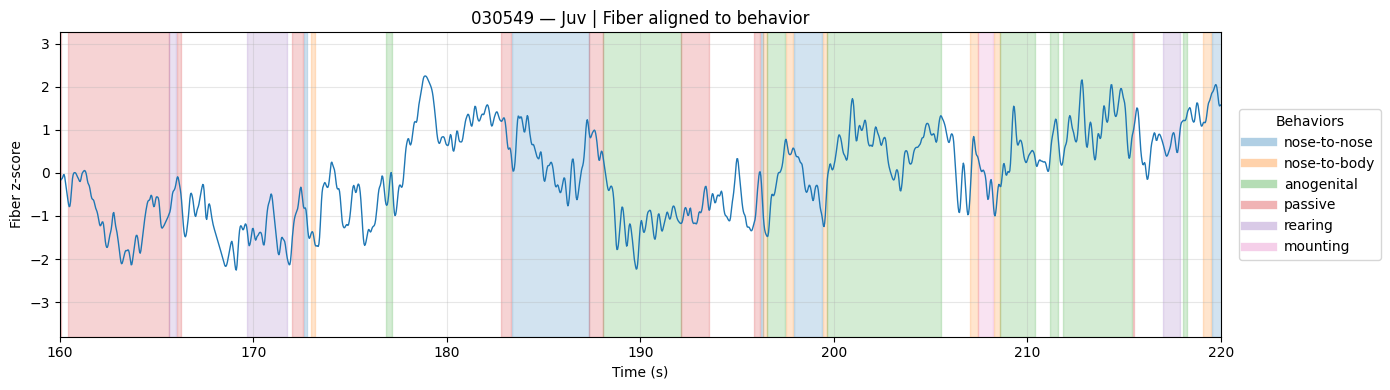

030549-Juv: average bout duration (s)
            anogenital: 1.423  (n_bouts=42)
              mounting: 0.533  (n_bouts=2)
          nose-to-body: 0.382  (n_bouts=33)
          nose-to-nose: 0.941  (n_bouts=17)
               passive: 1.210  (n_bouts=21)
               rearing: 1.206  (n_bouts=35)


In [20]:
import numpy as np
import matplotlib.pyplot as plt

def _binary_runs(time, binary_vec):
    """
    Return list of (t_start, t_end) for contiguous True runs in binary_vec.
    time: 1D array
    binary_vec: 1D bool array same length as time
    """
    time = np.asarray(time, float)
    b = np.asarray(binary_vec, bool)
    if time.size == 0 or b.size == 0 or time.size != b.size:
        return []

    db = np.diff(b.astype(int))
    starts = np.where(db == 1)[0] + 1
    ends = np.where(db == -1)[0] + 1

    if b[0]:
        starts = np.r_[0, starts]
    if b[-1]:
        ends = np.r_[ends, b.size]

    runs = []
    for s, e in zip(starts, ends):
        t0 = time[s]
        t1 = time[e - 1] if (e - 1) < time.size else time[-1]
        runs.append((float(t0), float(t1)))
    return runs


# results_by_key should already exist from the previous step:
# results_by_key = {(r["animal"], r["condition"]): r for r in result_list}

# Optional: set None for full range, or [start,end]
xlim = (160, 220)  # set to None to disable

for (animal_id, condition), rec in results_by_key.items():
    if "behavior" not in rec:
        continue

    beh = rec["behavior"].copy()

    # Time and aligned fiber
    if "time" not in beh.columns or "fiber_zscore_aligned" not in beh.columns:
        print(f"Skipping {animal_id}-{condition}: missing 'time' or 'fiber_zscore_aligned'")
        continue

    t = beh["time"].to_numpy(dtype=float)
    y = beh["fiber_zscore_aligned"].to_numpy(dtype=float)

    # Behavior columns: everything except time, aligned fiber, and optional Frames
    behavior_cols = [c for c in beh.columns if c not in ("time", "fiber_zscore_aligned", "Frames")]

    # Plot
    fig, ax = plt.subplots(figsize=(14, 4))
    ax.plot(t, y, lw=1.0, label="Fiber z-score (aligned)")

    # Colors
    color_cycle = plt.rcParams["axes.prop_cycle"].by_key().get("color", [])
    if not color_cycle:
        color_cycle = ["C0","C1","C2","C3","C4","C5","C6","C7","C8","C9"]

    legend_handles = []
    legend_labels = []

    # For duration stats
    dt = np.nanmedian(np.diff(t)) if t.size > 2 else np.nan

    avg_durations = {}  # behavior -> mean duration (s)
    n_bouts = {}        # behavior -> number of bouts

    for i, col in enumerate(behavior_cols):
        vals = beh[col].to_numpy()

        # interpret as binary (robust)
        b = np.isfinite(vals) & (vals > 0.5)

        runs = _binary_runs(t, b)
        if not runs:
            continue

        color = color_cycle[i % len(color_cycle)]

        # shade all bouts
        for (t0, t1) in runs:
            ax.axvspan(t0, t1, alpha=0.20, color=color)

        # legend (one entry per behavior)
        legend_handles.append(plt.Line2D([0], [0], color=color, lw=6, alpha=0.35))
        legend_labels.append(col)

        # duration stats
        durations = [(t1 - t0) for (t0, t1) in runs if np.isfinite(t0) and np.isfinite(t1)]
        if len(durations) > 0:
            avg_durations[col] = float(np.mean(durations))
            n_bouts[col] = int(len(durations))

    ax.set_title(f"{animal_id} — {condition} | Fiber aligned to behavior")
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("Fiber z-score")
    ax.grid(True, alpha=0.3)

    if xlim is not None:
        ax.set_xlim(xlim[0], xlim[1])

    # Put behavior legend outside
    if legend_handles:
        ax.legend(legend_handles, legend_labels, loc="center left",
                  bbox_to_anchor=(1.01, 0.5), title="Behaviors")
    else:
        ax.legend(loc="upper right")

    plt.tight_layout()
    plt.show()

    # ---- print average duration of each behavior ----
    if avg_durations:
        print(f"{animal_id}-{condition}: average bout duration (s)")
        for k in sorted(avg_durations.keys()):
            print(f"  {k:>20s}: {avg_durations[k]:.3f}  (n_bouts={n_bouts[k]})")
    else:
        print(f"{animal_id}-{condition}: no behavior bouts found.")



In [23]:
from typing import Tuple
from scipy.ndimage import gaussian_filter1d

def _compute_psth_matrix(
    t: np.ndarray,
    y: np.ndarray,
    event_times: np.ndarray,
    window: Tuple[float, float],
    baseline_win: Tuple[float, float],
    resample_hz: float,
    smooth_sigma_s: float = 0.0,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Returns:
      tvec (relative time), mat (n_events x n_samples) with NaNs if missing
    """
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    ev = np.asarray(event_times, float)
    ev = ev[np.isfinite(ev)]
    if ev.size == 0:
        return np.array([], float), np.zeros((0, 0), float)

    dt = 1.0 / float(resample_hz)
    tvec = np.arange(window[0], window[1] + 0.5 * dt, dt)

    mat = np.full((ev.size, tvec.size), np.nan, float)

    for i, et in enumerate(ev):
        # baseline
        bmask = (t >= et + baseline_win[0]) & (t <= et + baseline_win[1])
        base = y[bmask]
        if base.size < 5 or not np.any(np.isfinite(base)):
            continue
        bmean = np.nanmean(base)
        bstd = np.nanstd(base)
        if not np.isfinite(bstd) or bstd <= 1e-12:
            bstd = 1.0

        # extract window and interpolate onto tvec
        wmask = (t >= et + window[0]) & (t <= et + window[1])
        tw = t[wmask] - et
        yw = y[wmask]
        good = np.isfinite(tw) & np.isfinite(yw)
        if np.sum(good) < 5:
            continue
        # sparse interpolation
        mat[i, :] = np.interp(tvec, tw[good], (yw[good] - bmean) / bstd)

    if smooth_sigma_s and smooth_sigma_s > 0:
        # simple gaussian smoothing along time axis
        sigma = smooth_sigma_s * resample_hz
        mat = gaussian_filter1d(mat, sigma=sigma, axis=1, mode="nearest")

    return tvec, mat

import numpy as np

def extract_events(
    time,
    binary_vec,
    *,
    threshold=0.5,
    min_isi_s=0,
    min_duration_s=0.5,
    max_duration_s=None,
):

    t = np.asarray(time, float)
    v = np.asarray(binary_vec, float)

    good = np.isfinite(t) & np.isfinite(v)
    t = t[good]
    v = v[good]

    if t.size < 2:
        return {
            "onset_s": np.array([], dtype=float),
            "offset_s": np.array([], dtype=float),
            "duration_s": np.array([], dtype=float),
            "order": np.array([], dtype=int),
            "n_events": 0,
        }

    b = v > threshold
    if not np.any(b):
        return {
            "onset_s": np.array([], dtype=float),
            "offset_s": np.array([], dtype=float),
            "duration_s": np.array([], dtype=float),
            "order": np.array([], dtype=int),
            "n_events": 0,
        }

    # transitions in/out of True
    db = np.diff(b.astype(int))
    starts = np.where(db == 1)[0] + 1
    ends = np.where(db == -1)[0] + 1  # end is exclusive

    if b[0]:
        starts = np.r_[0, starts]
    if b[-1]:
        ends = np.r_[ends, b.size]

    on = t[starts]
    off_last = t[ends - 1]

    # Estimate dt for a better continuous-time offset estimate
    dt = float(np.nanmedian(np.diff(t))) if t.size > 2 else 0.0
    off = off_last + dt
    dur = off - on

    # Merge bouts based on onset spacing
    if min_isi_s and on.size > 1:
        merged_on = [on[0]]
        merged_off = [off[0]]

        for i in range(1, on.size):
            if (on[i] - merged_on[-1]) < float(min_isi_s):
                merged_off[-1] = max(merged_off[-1], off[i])
            else:
                merged_on.append(on[i])
                merged_off.append(off[i])

        on = np.asarray(merged_on, float)
        off = np.asarray(merged_off, float)
        dur = off - on

    # Duration filtering
    keep = np.ones_like(dur, dtype=bool)
    if min_duration_s is not None:
        keep &= dur >= float(min_duration_s)
    if max_duration_s is not None:
        keep &= dur <= float(max_duration_s)

    on = on[keep]
    off = off[keep]
    dur = dur[keep]

    # Event order (chronological)
    order = np.arange(on.size, dtype=int)

    return {
        "onset_s": on,
        "offset_s": off,
        "duration_s": dur,
        "order": order,
        "n_events": int(on.size),
    }


def get_behavior_cols_for_animal(animal_id):
    cols_union, seen = [], set()
    for cond in cond_order:
        rec = results_by_key.get((animal_id, cond))
        if rec is None or "behavior" not in rec:
            continue
        beh = rec["behavior"]
        cols = [c for c in beh.columns if c not in ("time", "fiber_zscore_aligned", "Frames")]
        for c in cols:
            if c not in seen:
                cols_union.append(c)
                seen.add(c)
    return cols_union

def plot_heatmap(ax, tvec, mat, title, show_ylabel=False):
    im = ax.imshow(
        mat,
        aspect="auto",
        origin="lower",
        extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
    )
    ax.axvline(0, color="w", linestyle="--", alpha=0.9, lw=1)
    ax.set_title(title, fontsize=10, pad=4)
    if show_ylabel:
        ax.set_ylabel("Trial", fontsize=9)
    ax.tick_params(axis="both", labelsize=8, length=2)
    return im


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4270764\2546964450.py:210: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.985])


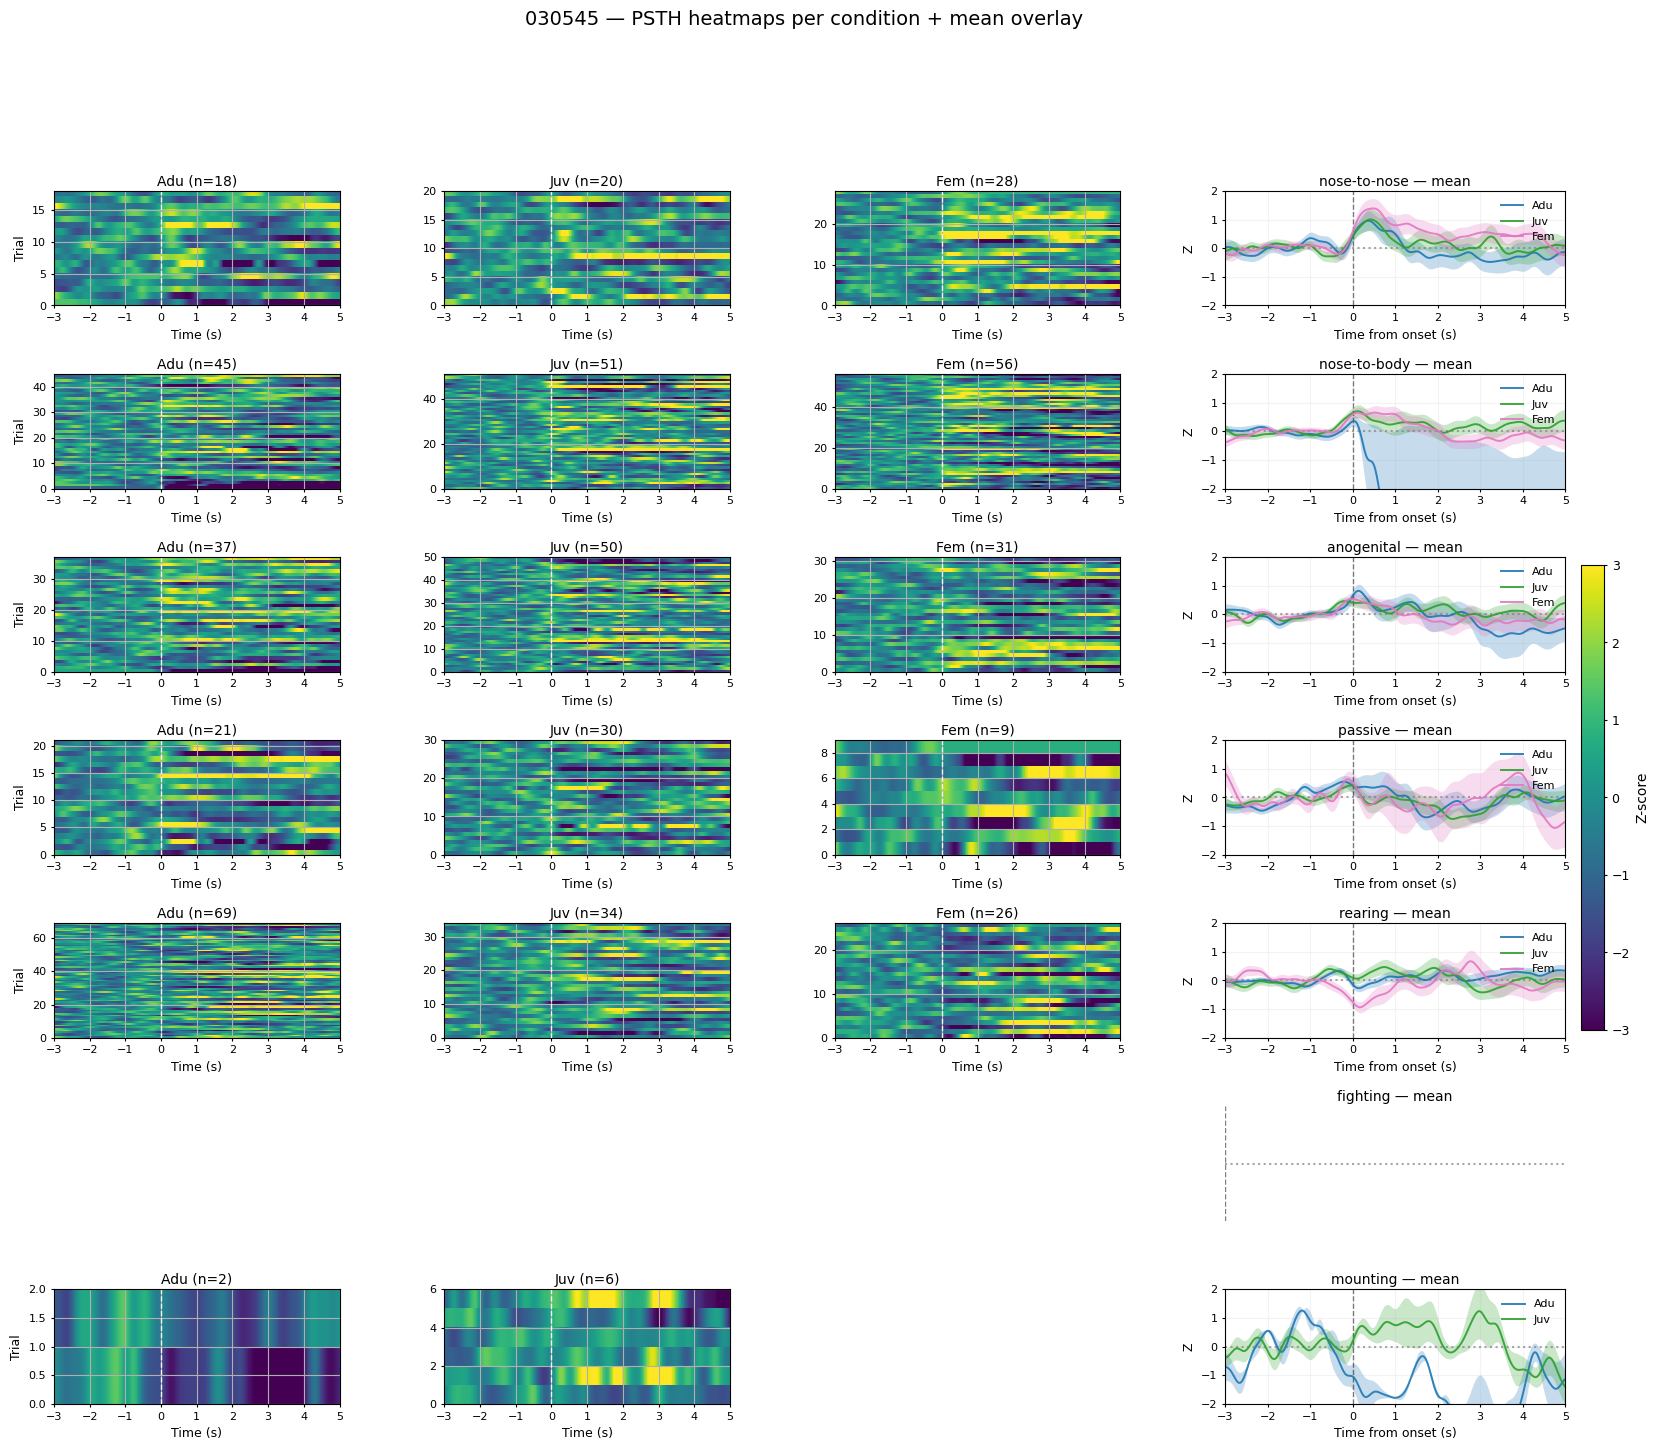

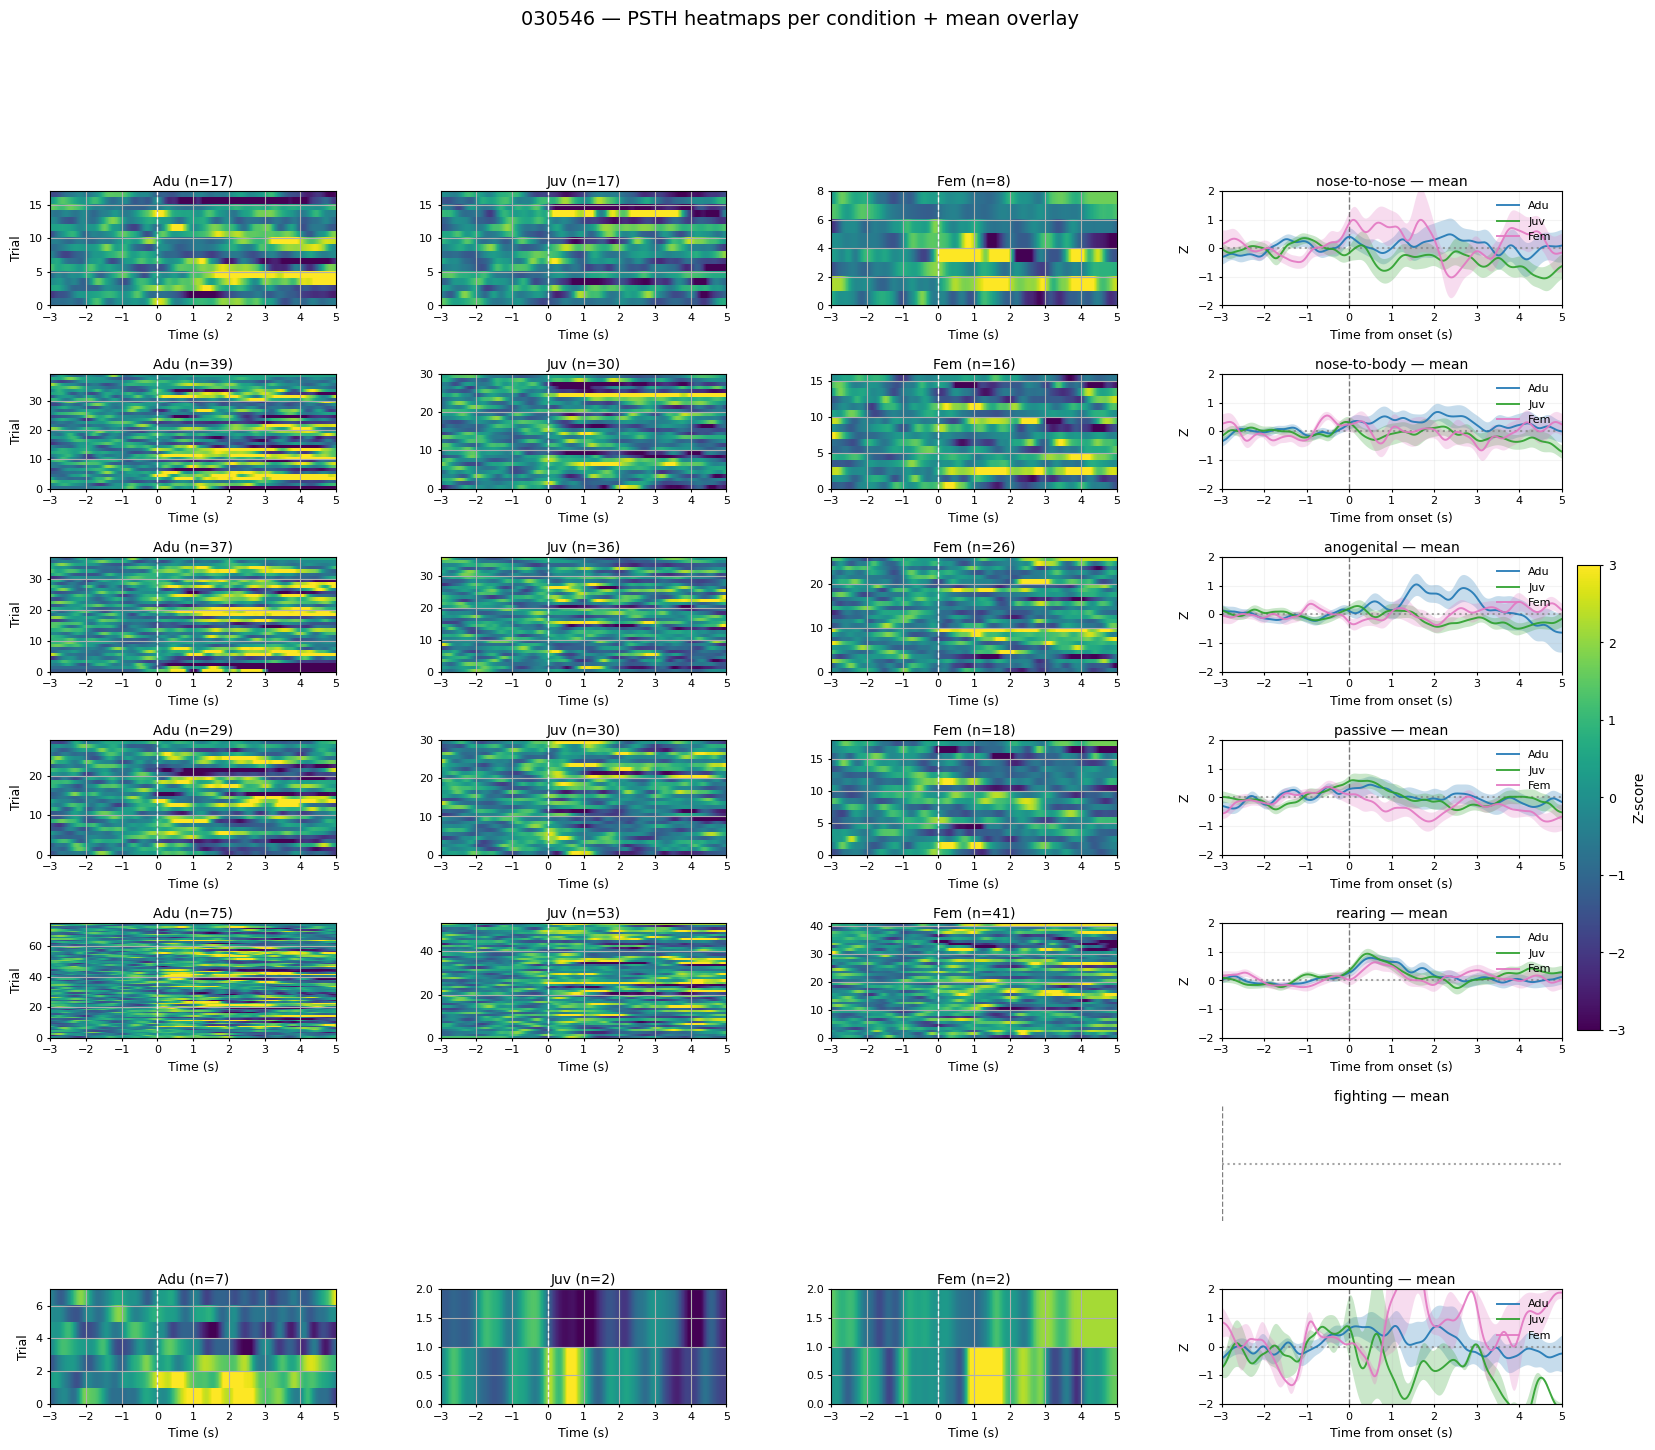

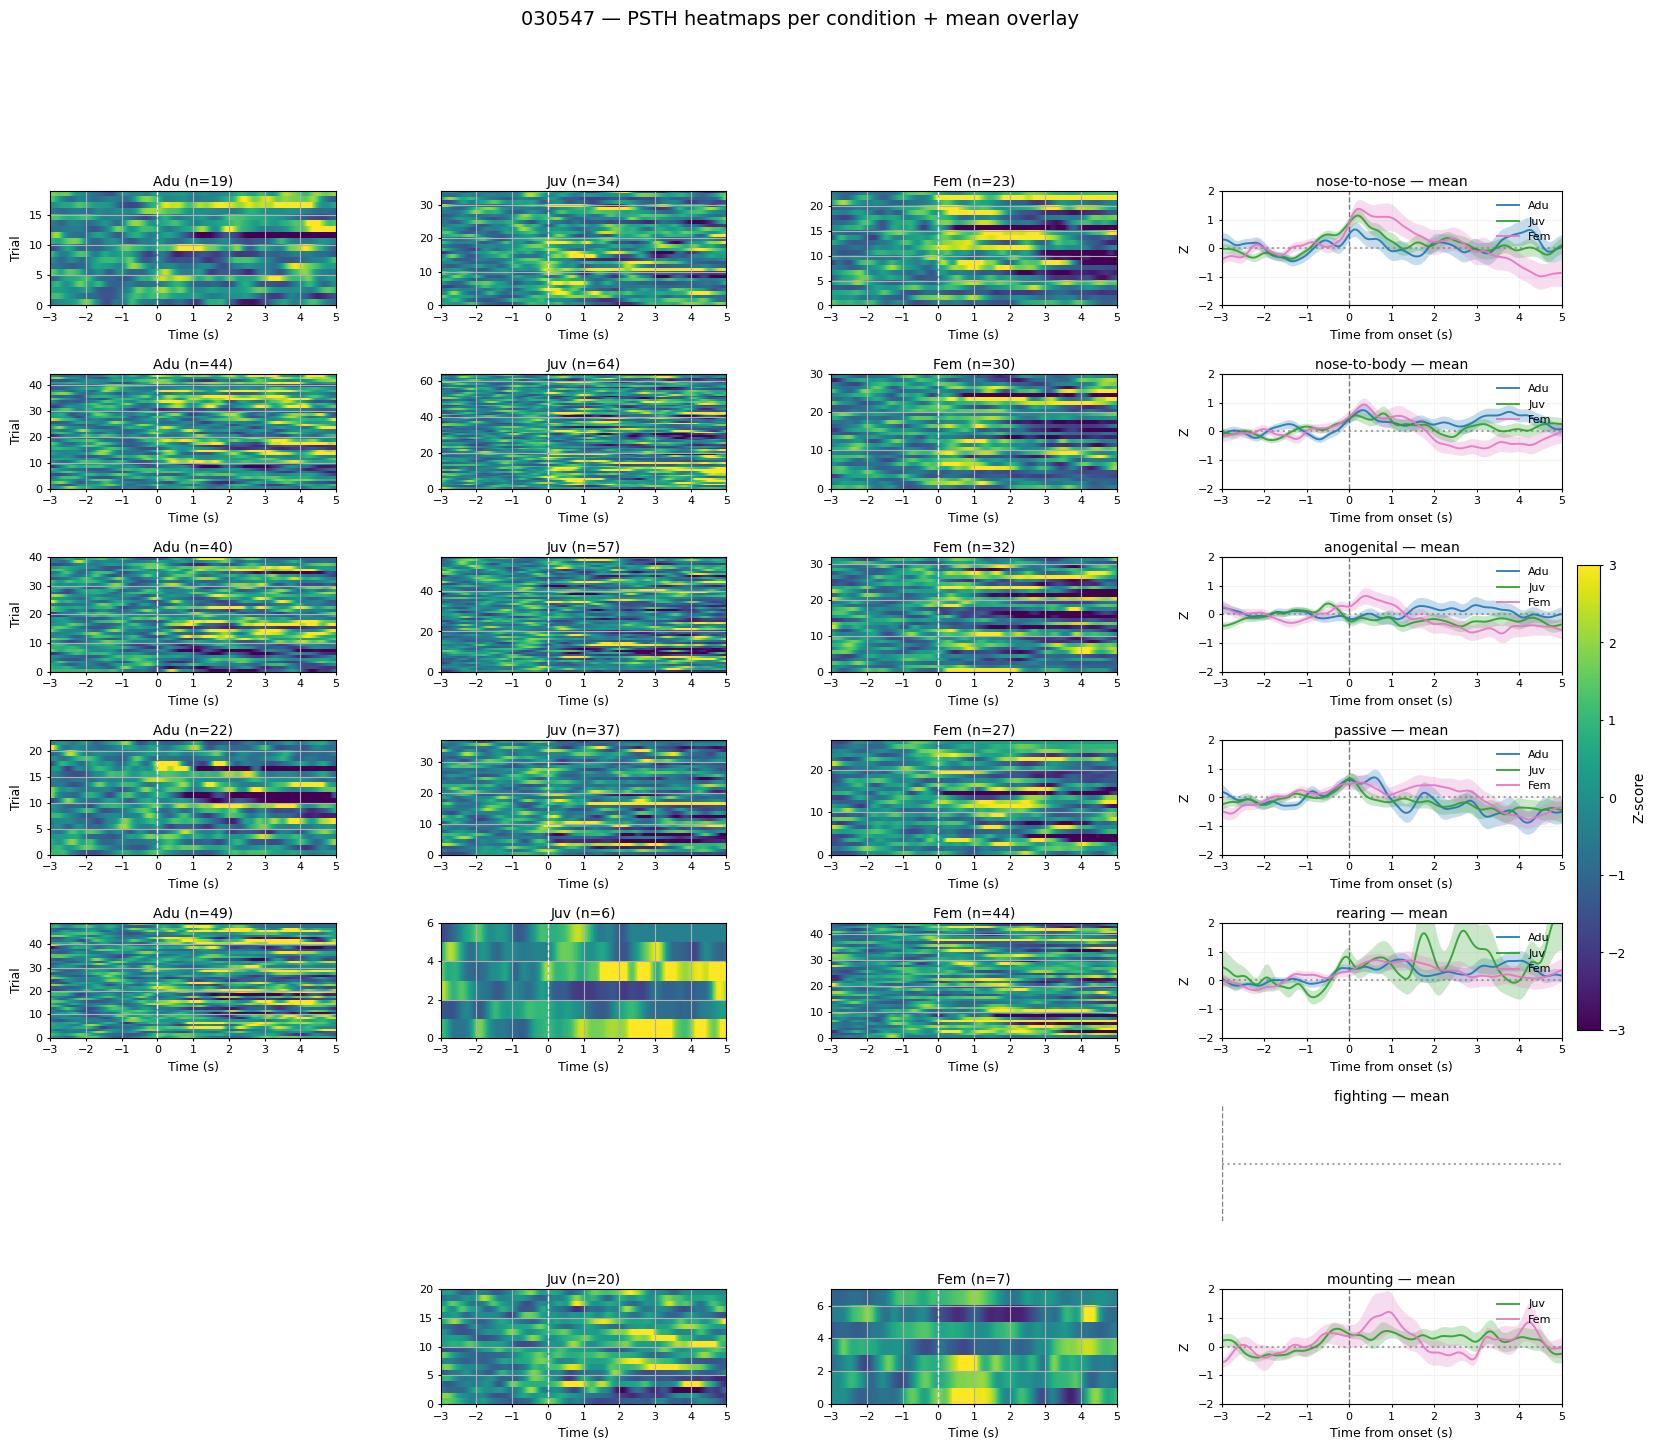

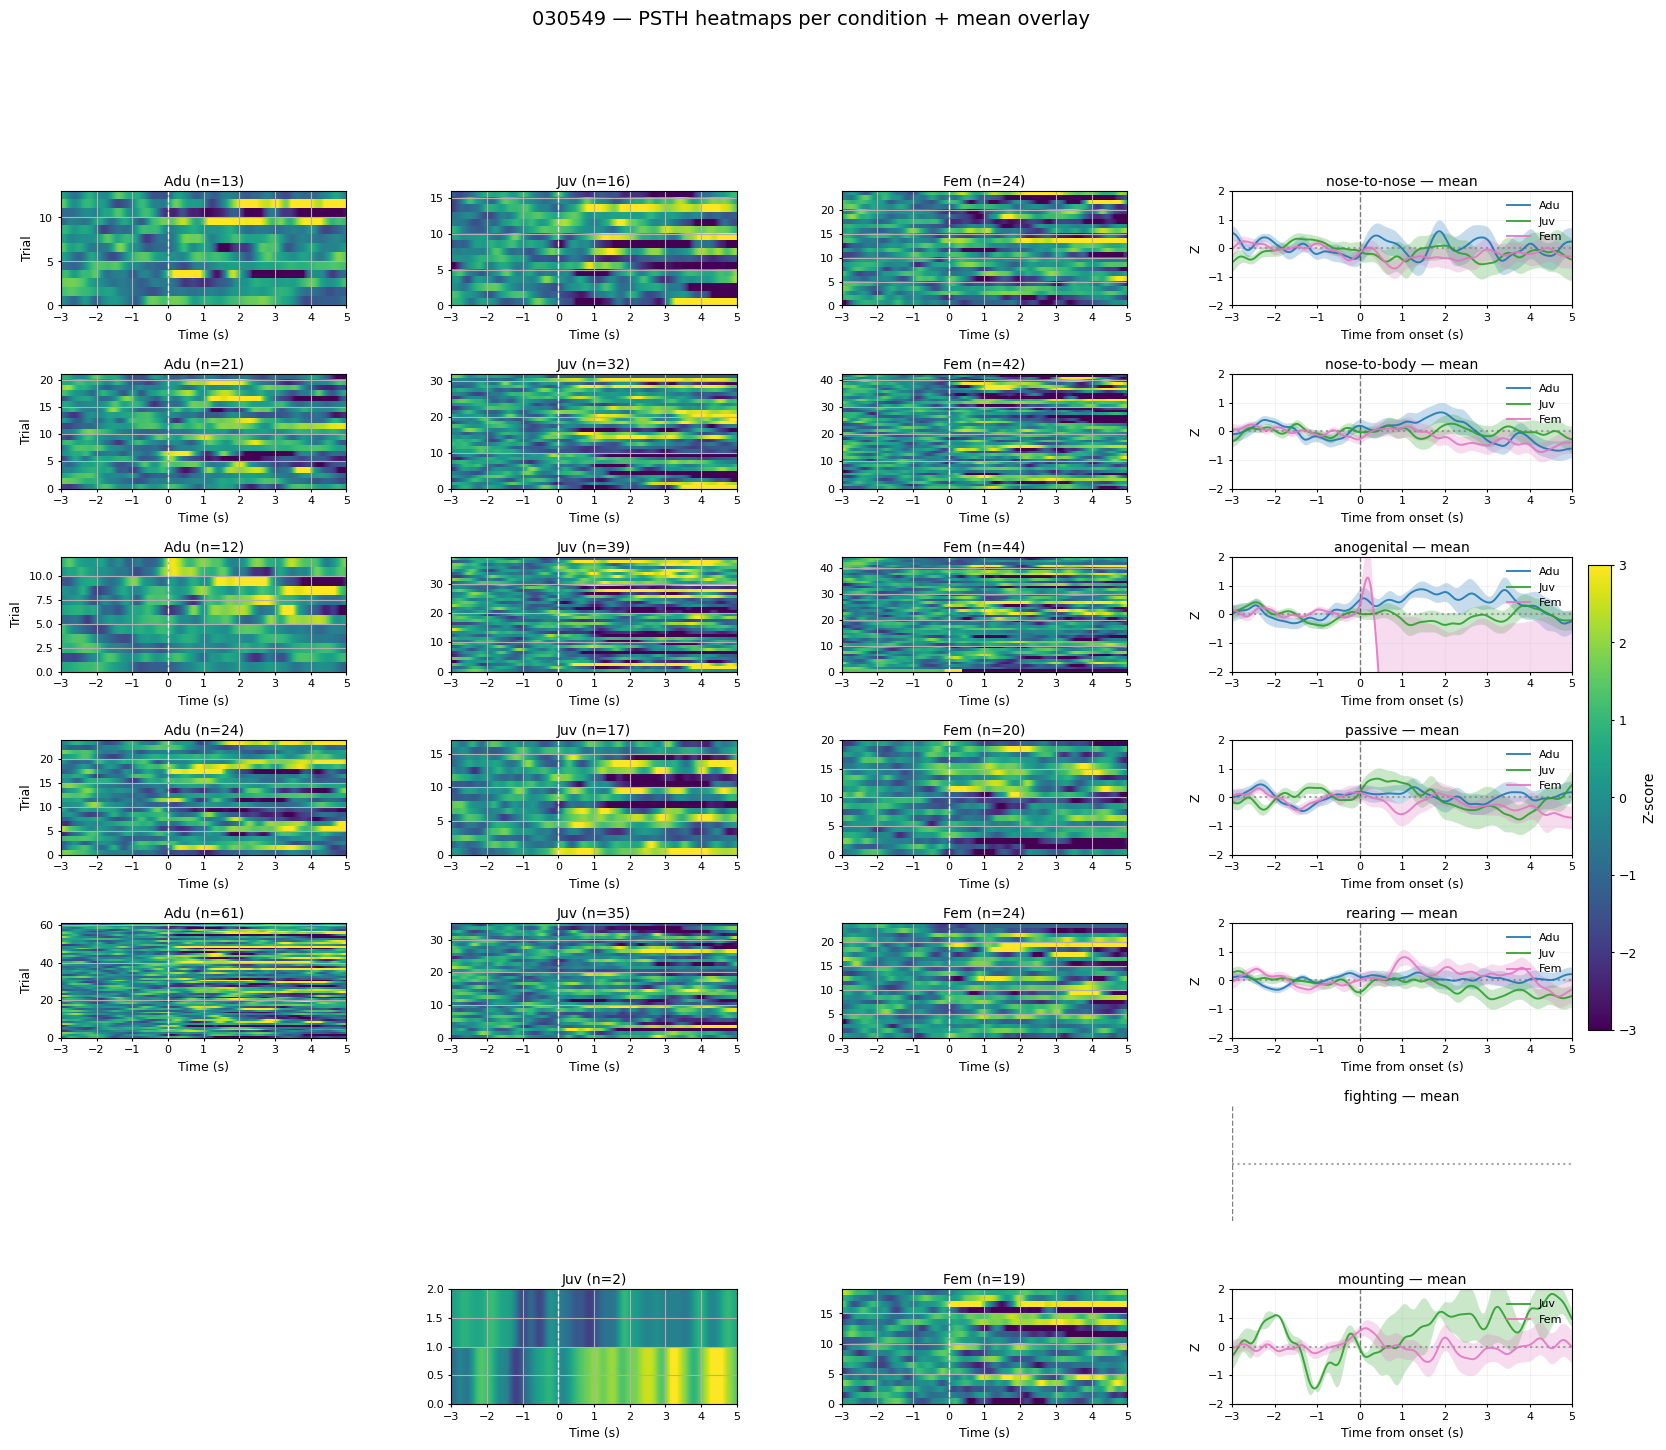

Stored PSTHs in psth_store for 84 (animal, condition, behavior) keys.


In [42]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# Parameters
# -----------------------------
window = (-3, 5)
baseline_win = (-3, 0)
smooth_sigma_s = 0.1

vmin, vmax = -3, 3
cmap = "viridis"
min_trials = 2

# Duration filter for events (seconds)
min_duration_s = 0.1   # <- you used 0.1 in your snippet; change as needed
max_duration_s = None

# Layout
figsize_base = (20, 2.25)  # (width, height_per_behavior_row)
mean_ylim = (-2, 2)

# Condition order & colors
cond_order = ["Adu", "Juv", "Fem"]
cond_colors = {"Adu": "tab:blue", "Juv": "tab:green", "Fem": "tab:pink"}
cond_alpha_line = 0.9
cond_alpha_fill = 0.25

# Storage dict (NEW)
psth_store = {}

# -----------------------------
# Plot: per animal
# -----------------------------
animals = sorted(set([k[0] for k in results_by_key.keys()]))

for animal_id in animals:
    behavior_cols = get_behavior_cols_for_animal(animal_id)
    if not behavior_cols:
        print(f"{animal_id}: no behavior columns found in any condition.")
        continue

    n_beh = len(behavior_cols)
    fig_w = figsize_base[0]
    fig_h = max(4, figsize_base[1] * n_beh)
    fig = plt.figure(figsize=(fig_w, fig_h), constrained_layout=False)

    gs = fig.add_gridspec(
        nrows=n_beh, ncols=4,
        width_ratios=[1.05, 1.05, 1.05, 1.25],
        wspace=0.35, hspace=0.60
    )

    fig.suptitle(f"{animal_id} — PSTH heatmaps per condition + mean overlay", y=0.995, fontsize=14)

    heatmap_images = []
    any_plotted_anywhere = False

    for r, beh_name in enumerate(behavior_cols):
        ax_hm = {cond: fig.add_subplot(gs[r, c]) for c, cond in enumerate(cond_order)}
        ax_mean = fig.add_subplot(gs[r, 3])

        # Mean axis styling
        ax_mean.axvline(0, color="k", linestyle="--", alpha=0.5, lw=1)
        ax_mean.axhline(0, color="gray", linestyle=":", alpha=0.7)
        ax_mean.set_title(f"{beh_name} — mean", fontsize=10, pad=4)
        ax_mean.set_ylabel("Z", fontsize=9)
        ax_mean.set_ylim(*mean_ylim)
        ax_mean.grid(True, alpha=0.15)
        ax_mean.tick_params(axis="both", labelsize=8, length=2)

        # Condition headers only on first row
        if r == 0:
            for cond in cond_order:
                ax_hm[cond].set_title(cond, fontsize=11, pad=6)

        ax_hm["Adu"].set_ylabel(f"{beh_name}\nTrial", fontsize=9)

        any_cond_plotted = False
        tvec_ref = None

        for cond in cond_order:
            rec = results_by_key.get((animal_id, cond), None)
            ax = ax_hm[cond]

            if rec is None or "behavior" not in rec:
                ax.axis("off")
                continue

            beh = rec["behavior"]
            if ("time" not in beh.columns) or ("fiber_zscore_aligned" not in beh.columns) or (beh_name not in beh.columns):
                ax.axis("off")
                continue

            fiber_time = beh["time"].to_numpy(dtype=float)
            fiber_trace = beh["fiber_zscore_aligned"].to_numpy(dtype=float)

            # ---- Use event dictionary ----
            ev = extract_events(
                fiber_time, beh[beh_name].to_numpy(),
                threshold=0,
                min_isi_s=0,
                min_duration_s=min_duration_s,
                max_duration_s=max_duration_s,
            )
            onsets = np.asarray(ev["onset_s"], float)

            # Store events even if not enough trials (NEW, useful for QA)
            psth_store[(animal_id, cond, beh_name)] = {
                "tvec": None,
                "psth_matrix": None,
                "mean": None,
                "sem": None,
                "n_trials": 0,
                "events": ev,
                "params": {
                    "window": window,
                    "baseline_win": baseline_win,
                    "smooth_sigma_s": smooth_sigma_s,
                    "min_trials": min_trials,
                    "min_duration_s": min_duration_s,
                    "max_duration_s": max_duration_s,
                },
            }

            if onsets.size < min_trials:
                ax.axis("off")
                continue

            # PSTH
            tvec, mat = _compute_psth_matrix(
                fiber_time, fiber_trace, onsets,
                window=window, baseline_win=baseline_win, smooth_sigma_s=smooth_sigma_s, resample_hz=60
            )
            mat = mat[~np.isnan(mat).all(axis=1)]
            if mat.shape[0] < min_trials:
                ax.axis("off")
                continue

            # Compute summary
            mean_trace = np.nanmean(mat, axis=0)
            sem_trace = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])

            # Store PSTH data (NEW)
            psth_store[(animal_id, cond, beh_name)].update({
                "tvec": tvec,
                "psth_matrix": mat,
                "mean": mean_trace,
                "sem": sem_trace,
                "n_trials": int(mat.shape[0]),
            })

            any_plotted_anywhere = True
            any_cond_plotted = True
            if tvec_ref is None:
                tvec_ref = tvec

            # Heatmap
            im = plot_heatmap(
                ax, tvec, mat,
                title=f"{cond} (n={mat.shape[0]})",
                show_ylabel=(cond == "Adu")
            )
            heatmap_images.append(im)

            # Mean overlay
            ax_mean.plot(
                tvec, mean_trace,
                color=cond_colors[cond],
                alpha=cond_alpha_line,
                lw=1.4,
                label=cond
            )
            ax_mean.fill_between(
                tvec, mean_trace - sem_trace, mean_trace + sem_trace,
                color=cond_colors[cond],
                alpha=cond_alpha_fill,
                linewidth=0
            )

        # Row formatting
        if any_cond_plotted and tvec_ref is not None:
            ax_mean.set_xlim(tvec_ref[0], tvec_ref[-1])
            ax_mean.legend(frameon=False, fontsize=8, loc="upper right")
            ax_mean.set_xlabel("Time from onset (s)", fontsize=9)
            for cond in cond_order:
                ax_hm[cond].set_xlabel("Time (s)", fontsize=9)
        else:
            ax_mean.axis("off")
            for cond in cond_order:
                ax_hm[cond].axis("off")

    if not any_plotted_anywhere:
        plt.close(fig)
        print(f"{animal_id}: nothing plotted (not enough events after filtering).")
        continue

    # Shared colorbar
    if heatmap_images:
        cbar = fig.colorbar(
            heatmap_images[0],
            ax=fig.axes,
            fraction=0.015,
            pad=0.01,
            shrink=0.85
        )
        cbar.set_label("Z-score", fontsize=10)
        cbar.ax.tick_params(labelsize=9, length=2)

    plt.tight_layout(rect=[0, 0, 1, 0.985])
    plt.show()

print(f"Stored PSTHs in psth_store for {len(psth_store)} (animal, condition, behavior) keys.")


In [31]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.stats import ttest_1samp, ttest_rel, friedmanchisquare


In [32]:
def strip_spines(ax):
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)

def interp_to_grid(tvec, y, tgrid):
    tvec = np.asarray(tvec, float)
    y = np.asarray(y, float)
    m = np.isfinite(tvec) & np.isfinite(y)
    if np.sum(m) < 2:
        return np.full_like(tgrid, np.nan, dtype=float)
    return np.interp(tgrid, tvec[m], y[m], left=np.nan, right=np.nan)

def auc_in_window(t, y, lo, hi):
    t = np.asarray(t, float)
    y = np.asarray(y, float)
    m = np.isfinite(t) & np.isfinite(y) & (t >= lo) & (t <= hi)
    if np.sum(m) < 2:
        return np.nan
    return float(np.trapz(y[m], t[m]))

def p_to_stars(p):
    if not np.isfinite(p):
        return "n/a"
    if p < 1e-3:
        return "***"
    if p < 1e-2:
        return "**"
    if p < 5e-2:
        return "*"
    return "ns"

def holm_adjust(pvals_dict):
    """
    Holm correction. Input: dict[key -> p]. Output: dict[key -> p_adj].
    """
    keys = list(pvals_dict.keys())
    items = [(k, pvals_dict[k]) for k in keys if np.isfinite(pvals_dict[k])]
    out = {k: np.nan for k in keys}
    if not items:
        return out

    items = sorted(items, key=lambda kv: kv[1])
    m = len(items)
    for i, (k, p) in enumerate(items):
        out[k] = min(1.0, p * (m - i))

    # monotone non-decreasing
    running = 0.0
    for k, _p in items:
        running = max(running, out[k])
        out[k] = running
    return out


In [33]:
# Conditions
cond_order = ["Adu", "Juv", "Fem"]
cond_colors = {"Adu": "tab:blue", "Juv": "tab:green", "Fem": "tab:pink"}

# AUC windows
auc_pre = (-2, 0)
auc_post = (0, 2)

# Heatmap display range (reduced)
vmin, vmax = -1, 1
cmap = "viridis"

# Minimum trials per (animal,cond,beh) to include in summary
min_trials_for_summary = 2

# Time grid for aggregation
tgrid = np.linspace(-3, 5, 400)

# Exclude behaviors
exclude_behaviors = {"fighting","mounting"}  # case-insensitive match

# Figure layout
fig_w = 24
row_h = 1.90

# columns: Adu hm, Juv hm, Fem hm, GRAND MEAN (bigger), Delta AUC
width_ratios = [1.0, 1.0, 1.25, 2, 0.7]  # <-- grand mean column is larger now
wspace = 0.18
hspace = 0.40

# Axis limits
mean_ylim = (-1.2, 2.2)
mean_xlim = (-3, 3)

In [34]:
# Collect animals + behaviors from psth_store
animals = sorted(set([k[0] for k in psth_store.keys()]))
behaviors_all = sorted(set([k[2] for k in psth_store.keys()]))

behaviors = []
for b in behaviors_all:
    if b is None:
        continue
    if str(b).strip().lower() in exclude_behaviors:
        continue
    behaviors.append(b)

if not animals:
    raise RuntimeError("No animals found in psth_store.")
if not behaviors:
    raise RuntimeError("No behaviors left after exclusions.")

# mats[(beh, cond)] = (animal_ids_used, M) where M is (n_animals, len(tgrid))
mats = {}
# deltas[(beh, cond)] = dict with animals list and delta array
deltas = {}

for beh in behaviors:
    for cond in cond_order:
        rows = []
        used_animals = []
        dA = []

        for animal in animals:
            key = (animal, cond, beh)
            if key not in psth_store:
                continue

            entry = psth_store[key]
            if entry.get("mean") is None or entry.get("tvec") is None:
                continue
            if int(entry.get("n_trials", 0)) < min_trials_for_summary:
                continue

            y = interp_to_grid(entry["tvec"], entry["mean"], tgrid)
            if np.all(~np.isfinite(y)):
                continue

            rows.append(y)
            used_animals.append(animal)

            pre = auc_in_window(tgrid, y, auc_pre[0], auc_pre[1])
            post = auc_in_window(tgrid, y, auc_post[0], auc_post[1])
            dA.append(post - pre if np.isfinite(pre) and np.isfinite(post) else np.nan)

        M = np.vstack(rows) if rows else np.zeros((0, tgrid.size), dtype=float)
        mats[(beh, cond)] = (used_animals, M)
        deltas[(beh, cond)] = {"animals": used_animals, "delta": np.asarray(dA, float)}

# Drop behaviors with no data in all conditions
behaviors_kept = []
for beh in behaviors:
    if any(mats[(beh, c)][1].shape[0] > 0 for c in cond_order):
        behaviors_kept.append(beh)
behaviors = behaviors_kept

print(f"Summary prepared for {len(behaviors)} behaviors, {len(animals)} animals.")


Summary prepared for 5 behaviors, 4 animals.


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4270764\1809578677.py:19: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  return float(np.trapz(y[m], t[m]))


In [35]:
def plot_summary_psth_deltaAUC(
    behaviors,
    mats,
    deltas,
    *,
    tgrid,
    cond_order,
    cond_colors,
    vmin=-1.5,
    vmax=1.5,
    cmap="viridis",
    fig_w=24,
    row_h=1.9,
    width_ratios=(1,1,1.25,2,0.8),
    wspace=0.18,
    hspace=0.40,
    mean_ylim=(-1.2, 2.2),
):
    plt.rcParams.update({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
    })

    nrows = len(behaviors)
    fig_h = max(6, row_h * nrows)

    fig = plt.figure(figsize=(fig_w, fig_h))
    gs = fig.add_gridspec(
        nrows=nrows, ncols=5,
        width_ratios=list(width_ratios),
        wspace=wspace, hspace=hspace
    )

    # Column headers (top row only)
    headers = ["Adu", "Juv", "Fem", "Grand mean (±SEM)", "ΔAUC (post−pre)"]
    for ci, title in enumerate(headers):
        axh = fig.add_subplot(gs[0, ci])
        axh.set_title(title, pad=10)
        axh.axis("off")

    heatmap_axes = []
    heatmap_mappable = None

    for r, beh in enumerate(behaviors):
        # -----------------
        # Heatmaps: cols 0..2
        # -----------------
        for c_i, cond in enumerate(cond_order):
            ax = fig.add_subplot(gs[r, c_i])
            strip_spines(ax)

            used_animals, M = mats[(beh, cond)]
            if M.shape[0] == 0:
                ax.axis("off")
                if c_i == 0:
                    ax.text(0.0, 0.5, f"{beh}\n(no data)", transform=ax.transAxes,
                            ha="left", va="center")
                continue

            im = ax.imshow(
                M, aspect="auto", origin="lower",
                extent=[tgrid[0], tgrid[-1], 0, M.shape[0]],
                cmap=cmap, vmin=vmin, vmax=vmax, interpolation="nearest"
            )
            heatmap_mappable = im
            heatmap_axes.append(ax)

            ax.axvline(0, color="w", linestyle="--", lw=1, alpha=0.9)

            if c_i == 0:
                ax.set_ylabel(f"{beh}\nAnimal", labelpad=6)
            else:
                ax.set_yticks([])

            if r == nrows - 1:
                ax.set_xlabel("Time (s)")
            else:
                ax.tick_params(labelbottom=False)

            ax.tick_params(length=2)

        # -----------------
        # Grand mean: col 3 (bigger)
        # -----------------
        axm = fig.add_subplot(gs[r, 3])
        strip_spines(axm)
        axm.axvline(0, color="k", linestyle="--", lw=1, alpha=0.35)
        axm.axhline(0, color="gray", linestyle=":", lw=1, alpha=0.6)
        axm.grid(True, alpha=0.15)

        any_plotted = False
        for cond in cond_order:
            used_animals, M = mats[(beh, cond)]
            if M.shape[0] == 0:
                continue

            mu = np.nanmean(M, axis=0)
            n_eff = np.sum(np.isfinite(M).any(axis=1))
            se = np.nanstd(M, axis=0) / np.sqrt(n_eff) if n_eff > 1 else np.full_like(mu, np.nan)

            axm.plot(tgrid, mu, color=cond_colors[cond], lw=2.0, alpha=0.95,
                     label=f"{cond} (n={M.shape[0]})")
            axm.fill_between(tgrid, mu - se, mu + se, color=cond_colors[cond],
                             alpha=0.20, linewidth=0)
            any_plotted = True

        axm.set_xlim(tgrid[0], tgrid[-1])
        axm.set_ylim(*mean_ylim)
        axm.set_ylabel("Z")

        if r == nrows - 1:
            axm.set_xlabel("Time (s)")
        else:
            axm.tick_params(labelbottom=False)

        if any_plotted:
            axm.legend(frameon=False, fontsize=8, loc="upper right")

        # -----------------
        # ΔAUC: col 4 with one-sample t-tests vs 0 + Friedman across conditions
        # -----------------
        axd = fig.add_subplot(gs[r, 4])
        strip_spines(axd)
        axd.grid(True, axis="y", alpha=0.15)
        axd.axhline(0, color="gray", linestyle=":", lw=1, alpha=0.7)

        x = np.arange(len(cond_order), dtype=float)
        rng = np.random.default_rng(0)

        # per-condition deltas + one-sample t-test vs 0
        means, ns, p_vs0 = [], [], {}
        cond_delta = {}

        for cond in cond_order:
            d = deltas[(beh, cond)]["delta"]
            d = d[np.isfinite(d)]
            cond_delta[cond] = d
            ns.append(int(d.size))
            means.append(np.nanmean(d) if d.size else np.nan)

            if d.size >= 2:
                p_vs0[cond] = float(ttest_1samp(d, 0.0, nan_policy="omit").pvalue)
            else:
                p_vs0[cond] = np.nan

        axd.bar(x, means, alpha=0.55, edgecolor="none")

        for i, cond in enumerate(cond_order):
            d = cond_delta[cond]
            if d.size == 0:
                continue
            jitter = (rng.random(d.size) - 0.5) * 0.16
            axd.scatter(x[i] + jitter, d, s=18, color=cond_colors[cond], alpha=0.85, edgecolors="none")

            axd.text(
                x[i],
                (means[i] if np.isfinite(means[i]) else 0.0) + 0.08*np.sign(means[i] if np.isfinite(means[i]) else 1),
                f"{p_to_stars(p_vs0[cond])}\n(n={ns[i]})",
                ha="center", va="bottom", fontsize=8
            )

        axd.set_xticks(x)
        axd.set_xticklabels(cond_order)
        axd.set_ylabel("ΔAUC")

        # Friedman (paired across conditions) on complete cases
        per_cond_map = {}
        sets = []
        for cond in cond_order:
            a_ids = deltas[(beh, cond)]["animals"]
            d_vals = deltas[(beh, cond)]["delta"]
            per_cond_map[cond] = {a: dv for a, dv in zip(a_ids, d_vals) if np.isfinite(dv)}
            sets.append(set(per_cond_map[cond].keys()))

        common = sorted(list(set.intersection(*sets))) if sets else []
        fried_p = np.nan

        if len(common) >= 3:
            X = np.vstack([[per_cond_map[cond][a] for a in common] for cond in cond_order])
            try:
                fried_p = float(friedmanchisquare(X[0], X[1], X[2]).pvalue)
            except Exception:
                fried_p = np.nan

            # If Friedman significant, do pairwise paired t-tests with Holm correction
            if np.isfinite(fried_p) and fried_p < 0.05:
                raw = {}
                pairs = [("Adu", "Juv"), ("Adu", "Fem"), ("Juv", "Fem")]
                for a, b in pairs:
                    xa = np.array([per_cond_map[a][k] for k in common], float)
                    xb = np.array([per_cond_map[b][k] for k in common], float)
                    raw[(a, b)] = float(ttest_rel(xa, xb, nan_policy="omit").pvalue)
                adj = holm_adjust(raw)

                # annotate pairwise brackets compactly
                y0 = np.nanmax([m for m in means if np.isfinite(m)] + [0.0]) + 0.25
                step = 0.18
                idx = {"Adu": 0, "Juv": 1, "Fem": 2}

                def bracket(i, j, y, txt):
                    axd.plot([i, i, j, j], [y, y+0.04, y+0.04, y], color="k", lw=0.8)
                    axd.text((i+j)/2, y+0.045, txt, ha="center", va="bottom", fontsize=8)

                kline = 0
                for (a, b), p in adj.items():
                    if not np.isfinite(p):
                        continue
                    bracket(idx[a], idx[b], y0 + kline*step, p_to_stars(p))
                    kline += 1

        # compact title with Friedman p
        if np.isfinite(fried_p):
            axd.set_title(f"{beh} | Friedman p={fried_p:.3g}", fontsize=9, pad=4)
        else:
            axd.set_title(f"{beh}", fontsize=9, pad=4)

        if r == nrows - 1:
            axd.set_xlabel("Condition")
        axd.tick_params(length=2)

    # Shared colorbar
    if heatmap_mappable is not None and heatmap_axes:
        cbar = fig.colorbar(
            heatmap_mappable,
            ax=heatmap_axes,
            fraction=0.02,
            pad=0.01,
            shrink=0.96
        )
        cbar.set_label("Z-score")
        cbar.ax.tick_params(length=2)

    fig.suptitle(
        "Summary across animals: mean PSTH heatmaps, grand means, and ΔAUC (t-tests vs 0)",
        y=0.998
    )
    plt.tight_layout(rect=[0, 0, 1, 0.985])
    plt.show()

    return fig


C:\Users\andrianj\AppData\Local\Temp\ipykernel_4270764\3768974167.py:100: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(M, axis=0)
C:\Users\andrianj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andrianj\AppData\Local\Temp\ipykernel_4270764\3768974167.py:100: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(M, axis=0)
C:\Users\andrianj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
C:\Users\andrianj\AppData\Local\Temp\ipykernel_4270764\3768974167.py:100: RuntimeWarning: Mean of empty slice
  mu = np.nanmean(M, axis=0)
C:\Users\andrianj\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\_nanfunctions_impl.py:2035: RuntimeWarning: De

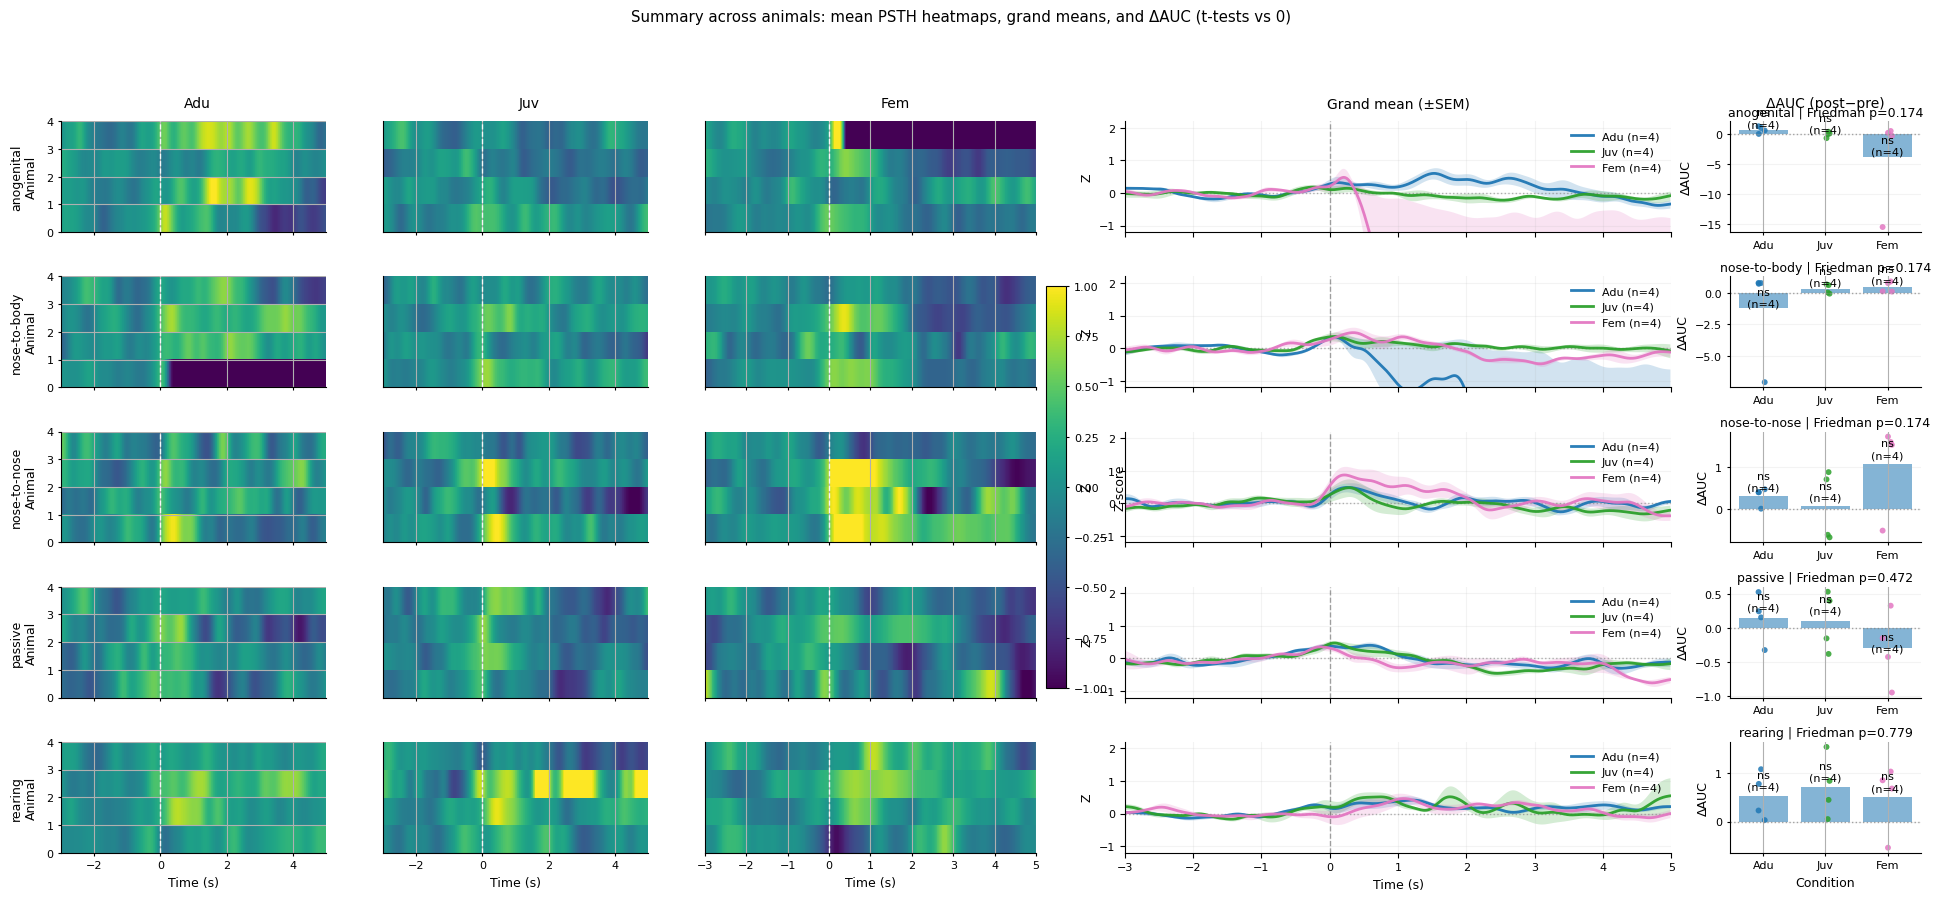

In [36]:
fig = plot_summary_psth_deltaAUC(
    behaviors,
    mats,
    deltas,
    tgrid=tgrid,
    cond_order=cond_order,
    cond_colors=cond_colors,
    vmin=vmin,
    vmax=vmax,
    cmap=cmap,
    fig_w=fig_w,
    row_h=row_h,
    width_ratios=width_ratios,
    wspace=wspace,
    hspace=hspace,
    mean_ylim=mean_ylim,
)

# Optional publication export
# fig.savefig("summary_psth_deltaAUC_ttests.png", dpi=300, bbox_inches="tight")


In [37]:
import numpy as np

def build_onset_event_sequence(
    beh_df,
    behavior_cols,
    *,
    threshold=0.5,
    min_isi_s=0.1,
    min_duration_s=None,
    max_duration_s=None,
):
    """
    Returns a sorted event sequence as:
      times: np.ndarray shape (n_events,)
      labels: np.ndarray shape (n_events,) dtype=object
    using extract_events(...) (event dictionary).
    """
    if "time" not in beh_df.columns:
        return np.array([]), np.array([], dtype=object)

    t = beh_df["time"].to_numpy(dtype=float)

    all_times = []
    all_labels = []

    for col in behavior_cols:
        if col not in beh_df.columns:
            continue
        ev = extract_events(
            t, beh_df[col].to_numpy(),
            threshold=threshold,
            min_isi_s=min_isi_s,
            min_duration_s=min_duration_s,
            max_duration_s=max_duration_s,
        )
        on = np.asarray(ev["onset_s"], float)
        if on.size == 0:
            continue
        all_times.append(on)
        all_labels.append(np.array([col] * on.size, dtype=object))

    if not all_times:
        return np.array([]), np.array([], dtype=object)

    times = np.concatenate(all_times)
    labels = np.concatenate(all_labels)

    order = np.argsort(times)
    return times[order], labels[order]


def transition_counts_and_probs(
    event_times,
    event_labels,
    behavior_cols,
    *,
    max_dt_s=1.0,
    drop_self=False
):
    """
    Compute transition counts and row-normalized probabilities.
    Transition = next onset within <= max_dt_s.

    Returns:
      counts: (B,B)
      probs:  (B,B) row-normalized (rows sum to 1 when row has outgoing transitions)
      row_totals: (B,) number of outgoing transitions per behavior
    """
    B = len(behavior_cols)
    idx = {b: i for i, b in enumerate(behavior_cols)}

    counts = np.zeros((B, B), dtype=int)

    if event_times.size < 2:
        probs = np.zeros((B, B), dtype=float)
        return counts, probs, np.zeros((B,), dtype=int)

    for i in range(len(event_times) - 1):
        t0, t1 = float(event_times[i]), float(event_times[i + 1])
        if not np.isfinite(t0) or not np.isfinite(t1):
            continue
        dt = t1 - t0
        if dt <= 0 or dt > max_dt_s:
            continue

        a = event_labels[i]
        b = event_labels[i + 1]
        if (a not in idx) or (b not in idx):
            continue
        ia, ib = idx[a], idx[b]
        if drop_self and ia == ib:
            continue
        counts[ia, ib] += 1

    row_totals = counts.sum(axis=1)
    probs = np.zeros_like(counts, dtype=float)
    nz = row_totals > 0
    probs[nz, :] = counts[nz, :] / row_totals[nz, None]
    return counts, probs, row_totals


# -------------------------
# Compute for each (animal, condition)
# -------------------------
cond_order = ["Adu", "Juv", "Fem"]
exclude_cols = {"time", "fiber_zscore_aligned", "Frames"}

transition_results = {}  # (animal, cond) -> dict(counts, probs, behaviors, row_totals, n_events)

# optional filters for event extraction
min_duration_s = None
max_duration_s = None

max_dt_s = 0.5   # transition window (<=1s)
drop_self = False  # set True if you want to ignore A->A

for (animal, cond), rec in results_by_key.items():
    if cond not in cond_order:
        continue
    if "behavior" not in rec:
        continue

    beh_df = rec["behavior"]
    behavior_cols = [c for c in beh_df.columns if c not in exclude_cols]
    if len(behavior_cols) == 0:
        continue

    times, labels = build_onset_event_sequence(
        beh_df, behavior_cols,
        threshold=0.5,
        min_isi_s=0.1,
        min_duration_s=min_duration_s,
        max_duration_s=max_duration_s,
    )

    counts, probs, row_totals = transition_counts_and_probs(
        times, labels, behavior_cols,
        max_dt_s=max_dt_s,
        drop_self=drop_self
    )

    transition_results[(animal, cond)] = {
        "behaviors": behavior_cols,
        "event_times": times,
        "event_labels": labels,
        "counts": counts,
        "probs": probs,
        "row_totals": row_totals,
        "n_events": int(times.size),
    }

print(f"Computed transition matrices for {len(transition_results)} (animal, condition) recordings.")


Computed transition matrices for 12 (animal, condition) recordings.


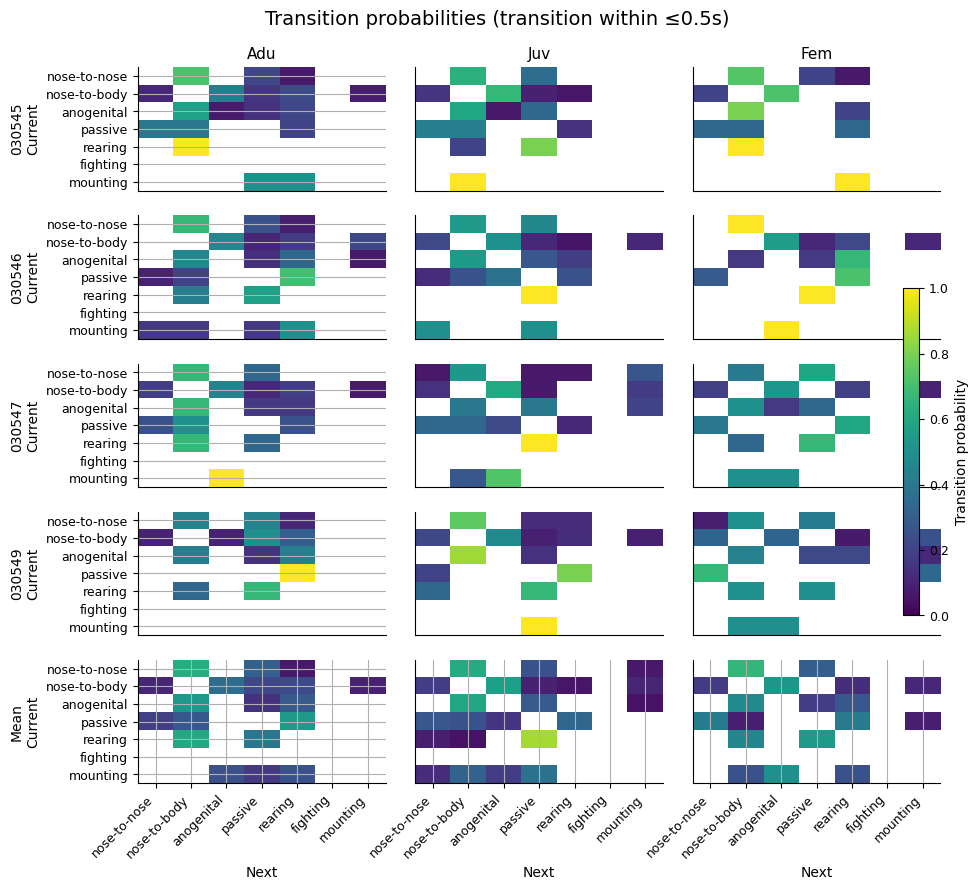

In [38]:
import numpy as np
import matplotlib.pyplot as plt

def plot_transition_grid_pretty(
    transition_results,
    *,
    cond_order=("Adu", "Juv", "Fem"),
    animals=None,
    global_labels=None,
    max_dt_s=None,
    title="Transition probabilities",
    vmax=None,
    vmin=0.0,
    cmap="viridis",
    show_xticks_on="bottom",   # "bottom" or "all" or "none"
    show_yticks_on="left",     # "left" or "all" or "none"
    mask_below=None,           # e.g. 0.05 to hide tiny probs
    annotate=False,
    fontsize=9,
    cbar_shrink=0.85,
):
    keys = list(transition_results.keys())
    if animals is None:
        animals = sorted(set([a for (a, c) in keys]))
    cond_order = list(cond_order)

    # Build union label order if not given
    if global_labels is None:
        seen = set()
        global_labels = []
        for a in animals:
            for c in cond_order:
                d = transition_results.get((a, c), None)
                if d is None:
                    continue
                for lab in d.get("behaviors", []):
                    if lab not in seen:
                        seen.add(lab)
                        global_labels.append(lab)

    nB = len(global_labels)
    if nB == 0:
        raise ValueError("No behaviors found.")

    # Align matrices to global label set
    aligned = {}
    all_vals = []
    for a in animals:
        for c in cond_order:
            d = transition_results.get((a, c), None)
            if d is None:
                continue
            probs = np.asarray(d["probs"], float)
            labels = list(d["behaviors"])
            old_idx = {lab: i for i, lab in enumerate(labels)}
            new_idx = {lab: i for i, lab in enumerate(global_labels)}
            M = np.full((nB, nB), np.nan, float)
            for li in labels:
                if li not in new_idx:
                    continue
                for lj in labels:
                    if lj not in new_idx:
                        continue
                    M[new_idx[li], new_idx[lj]] = probs[old_idx[li], old_idx[lj]]
            aligned[(a, c)] = M
            if np.isfinite(M).any():
                all_vals.append(np.nanmax(M))

    # Mean across animals per condition
    mean_by_cond = {}
    for c in cond_order:
        mats = [aligned[(a, c)] for a in animals if (a, c) in aligned]
        if mats:
            mean_by_cond[c] = np.nanmean(np.stack(mats, axis=0), axis=0)
        else:
            mean_by_cond[c] = np.full((nB, nB), np.nan, float)

    # Color scaling
    if vmax is None:
        vmax = float(np.nanmax(all_vals)) if all_vals else 1.0
        vmax = max(vmax, 1e-6)

    # Figure grid
    nrows = len(animals) + 1
    ncols = len(cond_order)

    # size heuristic: widen columns, keep readable labels
    fig_w = max(10, 3.1 * ncols + 0.18 * nB)
    fig_h = max(7, 1.6 * nrows + 0.12 * nB)
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(fig_w, fig_h), squeeze=False)

    # for shared cbar
    mappable = None

    def _style_ax(ax):
        ax.spines["top"].set_visible(False)
        ax.spines["right"].set_visible(False)

    def _maybe_mask(M):
        if mask_below is None:
            return M
        Mm = M.copy()
        Mm[np.isfinite(Mm) & (Mm < mask_below)] = np.nan
        return Mm

    # plot rows: animals
    for r, a in enumerate(animals):
        for ci, c in enumerate(cond_order):
            ax = axes[r, ci]
            M = aligned.get((a, c), np.full((nB, nB), np.nan))
            M = _maybe_mask(M)

            im = ax.imshow(M, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto", interpolation="nearest")
            mappable = im

            # titles only top row
            if r == 0:
                ax.set_title(c, fontsize=fontsize+2, pad=6)

            # y-label only first col
            if ci == 0:
                ax.set_ylabel(f"{a}\nCurrent", fontsize=fontsize+1)
            else:
                ax.set_ylabel("")

            # ticks
            if show_yticks_on in ("left", "all") and ci == 0:
                ax.set_yticks(np.arange(nB))
                ax.set_yticklabels(global_labels, fontsize=fontsize)
            elif show_yticks_on == "all":
                ax.set_yticks(np.arange(nB))
                ax.set_yticklabels(global_labels, fontsize=fontsize)
            else:
                ax.set_yticks([])

            if show_xticks_on == "all":
                ax.set_xticks(np.arange(nB))
                ax.set_xticklabels(global_labels, rotation=45, ha="right", fontsize=fontsize)
                ax.set_xlabel("Next", fontsize=fontsize+1)
            elif show_xticks_on == "bottom" and r == (nrows - 1):
                ax.set_xticks(np.arange(nB))
                ax.set_xticklabels(global_labels, rotation=45, ha="right", fontsize=fontsize)
                ax.set_xlabel("Next", fontsize=fontsize+1)
            else:
                ax.set_xticks([])

            # event marker aesthetics: optional diagonal emphasis
            ax.axvline(-0.5, color="none")
            _style_ax(ax)

            if annotate and np.isfinite(M).any():
                for i in range(nB):
                    for j in range(nB):
                        v = M[i, j]
                        if np.isfinite(v) and v > 0:
                            ax.text(j, i, f"{v:.2f}", ha="center", va="center", fontsize=6, color="white")

    # last row: mean
    mean_r = len(animals)
    for ci, c in enumerate(cond_order):
        ax = axes[mean_r, ci]
        M = _maybe_mask(mean_by_cond[c])
        im = ax.imshow(M, vmin=vmin, vmax=vmax, cmap=cmap, aspect="auto", interpolation="nearest")
        mappable = im

        if ci == 0:
            ax.set_ylabel("Mean\nCurrent", fontsize=fontsize+1)

        # show xticks on mean row
        ax.set_xticks(np.arange(nB))
        ax.set_xticklabels(global_labels, rotation=45, ha="right", fontsize=fontsize)
        ax.set_xlabel("Next", fontsize=fontsize+1)

        # show yticks only left
        if ci == 0:
            ax.set_yticks(np.arange(nB))
            ax.set_yticklabels(global_labels, fontsize=fontsize)
        else:
            ax.set_yticks([])

        _style_ax(ax)

    # shared colorbar
    if mappable is not None:
        cbar = fig.colorbar(
            mappable, ax=axes.ravel().tolist(),
            fraction=0.02, pad=0.015, shrink=cbar_shrink
        )
        cbar.set_label("Transition probability", fontsize=fontsize+1)
        cbar.ax.tick_params(labelsize=fontsize)

    # super title
    if max_dt_s is not None:
        fig.suptitle(f"{title} (transition within ≤{max_dt_s:.1f}s)", y=0.995, fontsize=fontsize+5)
    else:
        fig.suptitle(title, y=0.995, fontsize=fontsize+5)

    # tighter layout
    plt.subplots_adjust(left=0.16, right=0.92, top=0.93, bottom=0.12, wspace=0.12, hspace=0.20)
    plt.show()

    return {"global_behaviors": global_labels, "aligned": aligned, "mean_by_cond": mean_by_cond}


# --- run it ---
_ = plot_transition_grid_pretty(
    transition_results,
    cond_order=["Adu", "Juv", "Fem"],
    max_dt_s=max_dt_s,
    mask_below=0.05,          # hides tiny probabilities -> cleaner
    annotate=False,
    fontsize=9,
    title="Transition probabilities",
)


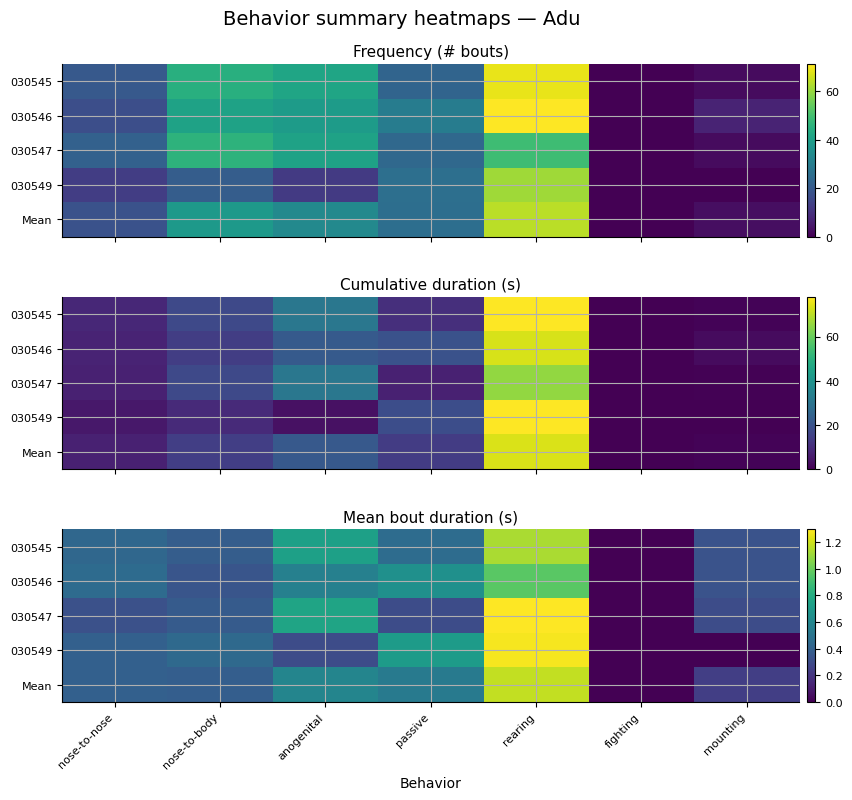

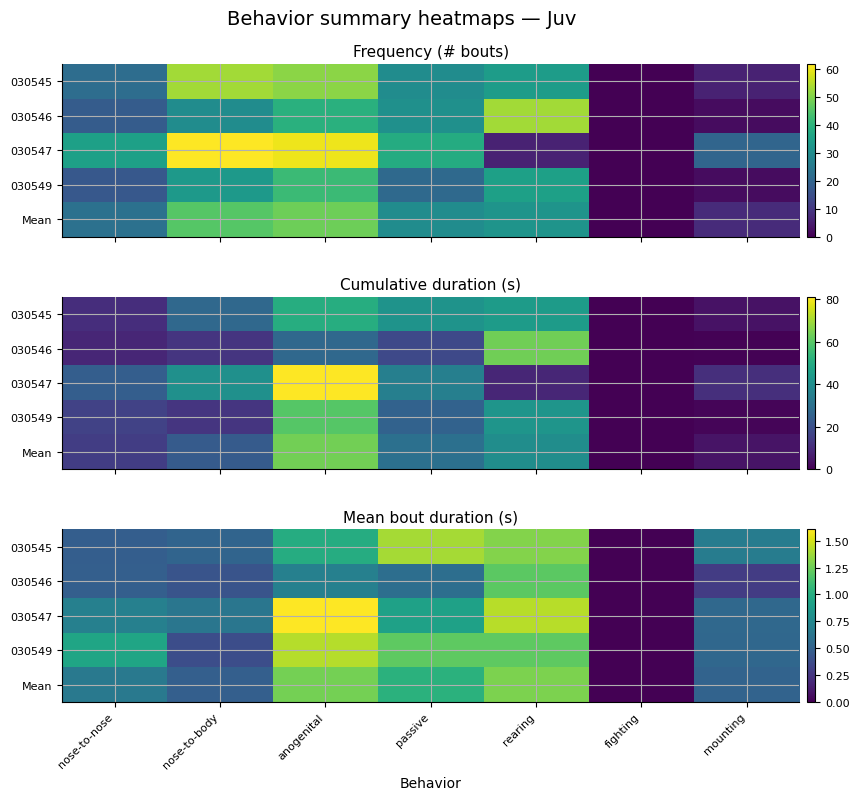

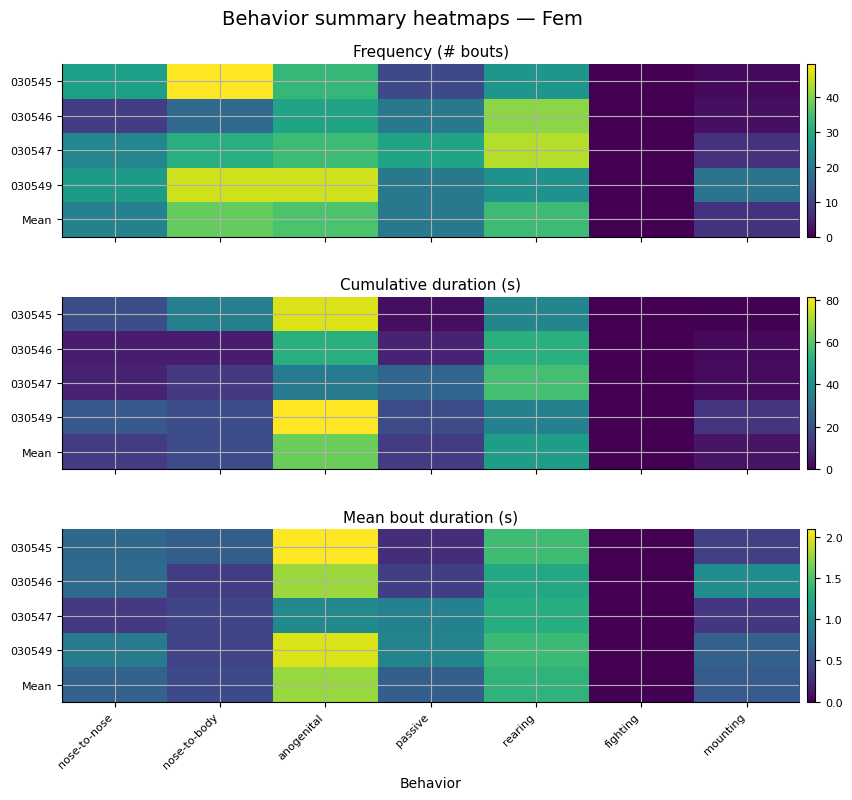

In [39]:
import numpy as np
import matplotlib.pyplot as plt

def extract_bouts(time, binary_vec, threshold=0.5):
    """
    Return bout start/end indices and start/end times for contiguous True runs.
    """
    t = np.asarray(time, float)
    v = np.asarray(binary_vec, float)
    m = np.isfinite(t) & np.isfinite(v)
    t = t[m]
    v = v[m]
    if t.size < 2:
        return []

    b = v > threshold
    db = np.diff(b.astype(int))
    starts = np.where(db == 1)[0] + 1
    ends   = np.where(db == -1)[0] + 1

    if b[0]:
        starts = np.r_[0, starts]
    if b[-1]:
        ends = np.r_[ends, b.size]

    bouts = []
    for s, e in zip(starts, ends):
        # e is exclusive index
        t0 = float(t[s])
        t1 = float(t[e-1]) if e-1 < t.size else float(t[-1])
        bouts.append((t0, t1))
    return bouts

def compute_behavior_summary(beh_df, behavior_cols, threshold=0.5):
    """
    Returns dict with:
      freq: number of bouts
      cum_dur: sum of bout durations (s)
      mean_bout_dur: mean bout duration (s)
    """
    t = beh_df["time"].to_numpy(dtype=float)
    out = {"freq": {}, "cum_dur": {}, "mean_bout_dur": {}}

    for bname in behavior_cols:
        bouts = extract_bouts(t, beh_df[bname].to_numpy(), threshold=threshold)
        freq = len(bouts)
        durs = np.array([max(0.0, (t1 - t0)) for (t0, t1) in bouts], float)
        out["freq"][bname] = float(freq)
        out["cum_dur"][bname] = float(np.sum(durs)) if durs.size else 0.0
        out["mean_bout_dur"][bname] = float(np.mean(durs)) if durs.size else 0.0

    return out

def plot_behavior_summary_heatmaps(
    results_by_key,
    *,
    cond_order=("Adu","Juv","Fem"),
    animals=None,
    behavior_cols=None,
    exclude=("fiber_zscore_aligned","Frames"),
    threshold=0.5,
    cmap="viridis",
    title="Behavior summaries"
):
    keys = list(results_by_key.keys())
    if animals is None:
        animals = sorted(set([a for (a,c) in keys]))
    cond_order = list(cond_order)

    # build behavior union if not provided
    if behavior_cols is None:
        seen = set()
        behavior_cols = []
        for a in animals:
            for c in cond_order:
                rec = results_by_key.get((a,c), None)
                if rec is None or "behavior" not in rec:
                    continue
                beh = rec["behavior"]
                cols = [col for col in beh.columns if col not in ("time",) + tuple(exclude)]
                for col in cols:
                    if col not in seen:
                        seen.add(col)
                        behavior_cols.append(col)

    nB = len(behavior_cols)
    if nB == 0:
        raise ValueError("No behavior columns found in results_by_key.")

    metrics = ["freq", "cum_dur", "mean_bout_dur"]
    metric_titles = {
        "freq": "Frequency (# bouts)",
        "cum_dur": "Cumulative duration (s)",
        "mean_bout_dur": "Mean bout duration (s)"
    }

    for cond in cond_order:
        # matrices: rows animals + mean, cols behaviors
        mats = {m: np.full((len(animals)+1, nB), np.nan, float) for m in metrics}

        # fill per animal
        for i, a in enumerate(animals):
            rec = results_by_key.get((a, cond), None)
            if rec is None or "behavior" not in rec:
                continue
            beh_df = rec["behavior"]
            if "time" not in beh_df.columns:
                continue
            summ = compute_behavior_summary(beh_df, behavior_cols, threshold=threshold)
            for j, bname in enumerate(behavior_cols):
                for m in metrics:
                    mats[m][i, j] = summ[m].get(bname, np.nan)

        # mean row
        for m in metrics:
            mats[m][-1, :] = np.nanmean(mats[m][0:len(animals), :], axis=0)

        # plot: 3 stacked heatmaps for this condition
        fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(max(10, 0.42*nB + 6), 8.5), sharex=True)
        fig.suptitle(f"{title} — {cond}", y=0.995, fontsize=14)

        for k, m in enumerate(metrics):
            ax = axes[k]
            M = mats[m]

            # choose vmax per metric for readability
            vmax = np.nanpercentile(M[np.isfinite(M)], 98) if np.isfinite(M).any() else 1.0
            vmax = max(vmax, 1e-6)

            im = ax.imshow(M, aspect="auto", cmap=cmap, vmin=0, vmax=vmax, interpolation="nearest")

            # y ticks: animals + Mean
            ylabels = animals + ["Mean"]
            ax.set_yticks(np.arange(len(ylabels)))
            ax.set_yticklabels(ylabels, fontsize=8)
            ax.set_title(metric_titles[m], fontsize=11, pad=6)

            ax.spines["top"].set_visible(False)
            ax.spines["right"].set_visible(False)

            cbar = fig.colorbar(im, ax=ax, fraction=0.02, pad=0.01)
            cbar.ax.tick_params(labelsize=8)

        axes[-1].set_xticks(np.arange(nB))
        axes[-1].set_xticklabels(behavior_cols, rotation=45, ha="right", fontsize=8)
        axes[-1].set_xlabel("Behavior", fontsize=10)

        plt.subplots_adjust(left=0.16, right=0.92, top=0.93, bottom=0.18, hspace=0.35)
        plt.show()


# --- run it ---
# Requires results_by_key[(animal, cond)]["behavior"] exists.
plot_behavior_summary_heatmaps(
    results_by_key,
    cond_order=["Adu", "Juv", "Fem"],
    title="Behavior summary heatmaps"
)


NameError: name 'compute_psth_matrix' is not defined

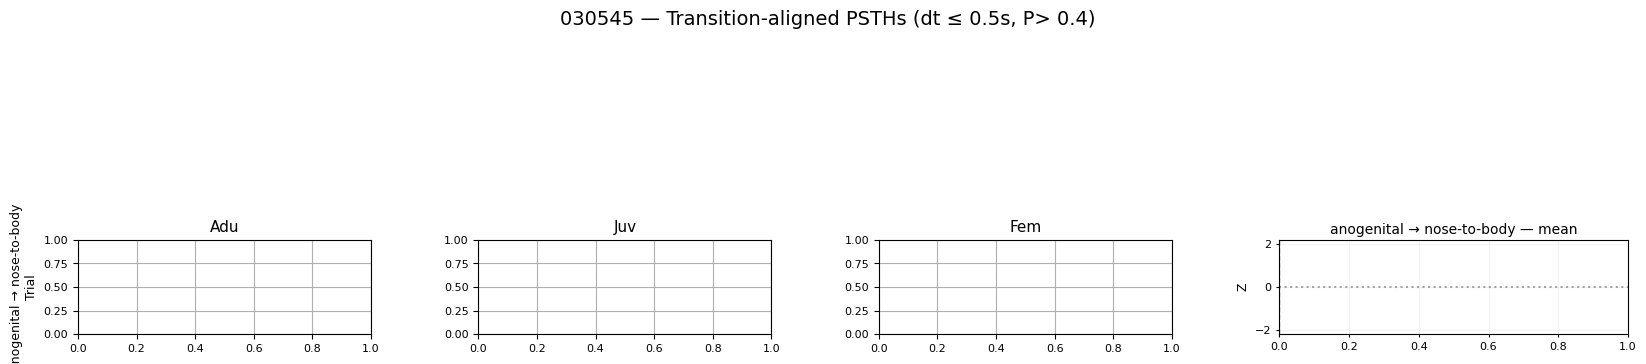

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# -----------------------------
# User parameters
# -----------------------------
transition_dt_s = 0.5        # transition window (<=1s)
prob_threshold = 0.4          # only keep pairs with P(B|A) > 0.5
min_transitions = 2           # minimum number of transition events to plot PSTH

# PSTH parameters
window = (-3, 5)
baseline_win = (-3, 0)
smooth_sigma_s = 0.1

# Heatmap scaling
vmin, vmax = -3, 3
cmap = "viridis"

# Optional duration filtering for event extraction (behavior bouts)
min_duration_s = None
max_duration_s = None

# Layout
figsize_base = (20, 2.0)      # (width, height_per_row); total height scales with #pairs
mean_ylim = (-2.2, 2.2)

# Conditions + requested colors
cond_order = ["Adu", "Juv", "Fem"]
cond_colors = {"Adu": "tab:blue", "Juv": "tab:green", "Fem": "tab:pink"}
cond_alpha_line = 0.9
cond_alpha_fill = 0.25

exclude_cols = {"time", "fiber_zscore_aligned", "Frames"}

# -----------------------------
# Helpers
# -----------------------------
def get_behavior_cols_for_animal(animal_id):
    cols_union, seen = [], set()
    for cond in cond_order:
        rec = results_by_key.get((animal_id, cond))
        if rec is None or "behavior" not in rec:
            continue
        beh = rec["behavior"]
        cols = [c for c in beh.columns if c not in exclude_cols]
        for c in cols:
            if c not in seen:
                cols_union.append(c)
                seen.add(c)
    return cols_union

def build_event_sequence_from_df(beh_df, behavior_cols):
    """
    Build a chronological sequence of behavior onset events.
    Returns (times, labels) sorted by time.
    """
    if "time" not in beh_df.columns:
        return np.array([]), np.array([], dtype=object)

    t = beh_df["time"].to_numpy(dtype=float)

    all_times = []
    all_labels = []

    for b in behavior_cols:
        if b not in beh_df.columns:
            continue
        ev = extract_events(
            t, beh_df[b].to_numpy(),
            threshold=0.5,
            min_isi_s=0.1,
            min_duration_s=min_duration_s,
            max_duration_s=max_duration_s,
        )
        on = np.asarray(ev["onset_s"], float)
        if on.size == 0:
            continue
        all_times.append(on)
        all_labels.append(np.array([b] * on.size, dtype=object))

    if not all_times:
        return np.array([]), np.array([], dtype=object)

    times = np.concatenate(all_times)
    labels = np.concatenate(all_labels)
    order = np.argsort(times)
    return times[order], labels[order]

def transition_counts_probs_and_times(event_times, event_labels, behavior_cols, max_dt_s=1.0):
    """
    Using the chronological event list, compute:
      - counts[A,B]
      - probs[A,B] = counts[A,B]/sum_B counts[A,B]
      - transition_times[(A,B)] = list of times at which transition occurs (here: onset time of B)
    Transition is only between consecutive events with dt <= max_dt_s.
    """
    B = len(behavior_cols)
    idx = {b: i for i, b in enumerate(behavior_cols)}

    counts = np.zeros((B, B), dtype=int)
    trans_times = {}  # (A,B) -> list of B-onset times

    if event_times.size < 2:
        probs = np.zeros((B, B), dtype=float)
        return counts, probs, trans_times

    for i in range(event_times.size - 1):
        t0 = float(event_times[i])
        t1 = float(event_times[i + 1])
        if not (np.isfinite(t0) and np.isfinite(t1)):
            continue
        dt = t1 - t0
        if dt <= 0 or dt > max_dt_s:
            continue

        A = event_labels[i]
        Bn = event_labels[i + 1]
        if A not in idx or Bn not in idx:
            continue

        ia, ib = idx[A], idx[Bn]
        counts[ia, ib] += 1
        trans_times.setdefault((A, Bn), []).append(t1)  # center on onset of next behavior

    row_totals = counts.sum(axis=1)
    probs = np.zeros_like(counts, dtype=float)
    nz = row_totals > 0
    probs[nz, :] = counts[nz, :] / row_totals[nz, None]

    return counts, probs, trans_times

def plot_heatmap(ax, tvec, mat, title, show_ylabel=False):
    im = ax.imshow(
        mat,
        aspect="auto",
        origin="lower",
        extent=[tvec[0], tvec[-1], 0, mat.shape[0]],
        cmap=cmap,
        vmin=vmin,
        vmax=vmax,
        interpolation="nearest",
    )
    ax.axvline(0, color="w", linestyle="--", alpha=0.9, lw=1)
    ax.set_title(title, fontsize=10, pad=4)
    if show_ylabel:
        ax.set_ylabel("Trial", fontsize=9)
    ax.tick_params(axis="both", labelsize=8, length=2)
    return im

# -----------------------------
# Plot: per animal, rows = high-probability transitions (A->B)
# -----------------------------
animals = sorted(set([k[0] for k in results_by_key.keys()]))

for animal_id in animals:
    behavior_cols = get_behavior_cols_for_animal(animal_id)
    if not behavior_cols:
        print(f"{animal_id}: no behaviors available.")
        continue

    # For each condition, compute transition probs + transition times
    cond_stats = {}
    candidate_pairs = set()

    for cond in cond_order:
        rec = results_by_key.get((animal_id, cond), None)
        if rec is None or "behavior" not in rec:
            continue

        beh_df = rec["behavior"]
        # Need aligned fiber too for PSTH
        if ("time" not in beh_df.columns) or ("fiber_zscore_aligned" not in beh_df.columns):
            continue

        event_times, event_labels = build_event_sequence_from_df(beh_df, behavior_cols)
        counts, probs, trans_times = transition_counts_probs_and_times(
            event_times, event_labels, behavior_cols, max_dt_s=transition_dt_s
        )

        cond_stats[cond] = {
            "beh_df": beh_df,
            "counts": counts,
            "probs": probs,
            "trans_times": trans_times,
        }

        # Collect pairs exceeding probability threshold in this condition
        for (A, Bn), times in trans_times.items():
            ia = behavior_cols.index(A)
            ib = behavior_cols.index(Bn)
            if probs[ia, ib] > prob_threshold:
                candidate_pairs.add((A, Bn))

    if not candidate_pairs:
        print(f"{animal_id}: no transitions with P(B|A) > {prob_threshold} in any condition.")
        continue

    # Sort pairs for stable display (by source then dest)
    candidate_pairs = sorted(candidate_pairs, key=lambda x: (x[0], x[1]))
    n_pairs = len(candidate_pairs)

    fig_w = figsize_base[0]
    fig_h = max(4, figsize_base[1] * n_pairs)
    fig = plt.figure(figsize=(fig_w, fig_h), constrained_layout=False)

    gs = fig.add_gridspec(
        nrows=n_pairs, ncols=4,
        width_ratios=[1.05, 1.05, 1.05, 1.25],
        wspace=0.35, hspace=0.70
    )

    fig.suptitle(
        f"{animal_id} — Transition-aligned PSTHs (dt ≤ {transition_dt_s:.1f}s, P> {prob_threshold})",
        y=0.995, fontsize=14
    )

    heatmap_images = []
    any_plotted = False

    for r, (A, Bn) in enumerate(candidate_pairs):
        pair_label = f"{A} → {Bn}"

        # axes
        ax_hm = {cond: fig.add_subplot(gs[r, c]) for c, cond in enumerate(cond_order)}
        ax_mean = fig.add_subplot(gs[r, 3])

        # Mean axis styling
        ax_mean.axvline(0, color="k", linestyle="--", alpha=0.5, lw=1)
        ax_mean.axhline(0, color="gray", linestyle=":", alpha=0.7)
        ax_mean.set_title(f"{pair_label} — mean", fontsize=10, pad=4)
        ax_mean.set_ylabel("Z", fontsize=9)
        ax_mean.set_ylim(*mean_ylim)
        ax_mean.grid(True, alpha=0.15)
        ax_mean.tick_params(axis="both", labelsize=8, length=2)

        # condition headers only on first row
        if r == 0:
            for cond in cond_order:
                ax_hm[cond].set_title(cond, fontsize=11, pad=6)

        # leftmost y label includes pair label
        ax_hm["Adu"].set_ylabel(f"{pair_label}\nTrial", fontsize=9)

        tvec_ref = None
        any_cond_row = False

        for cond in cond_order:
            ax = ax_hm[cond]
            if cond not in cond_stats:
                ax.axis("off")
                continue

            beh_df = cond_stats[cond]["beh_df"]
            probs = cond_stats[cond]["probs"]
            trans_times = cond_stats[cond]["trans_times"]

            # must have this transition in this condition and exceed threshold
            times = np.asarray(trans_times.get((A, Bn), []), float)
            if times.size < min_transitions:
                ax.axis("off")
                continue

            ia = behavior_cols.index(A)
            ib = behavior_cols.index(Bn)
            p_ab = float(probs[ia, ib])
            if p_ab <= prob_threshold:
                ax.axis("off")
                continue

            # fiber on behavior timebase
            fiber_time = beh_df["time"].to_numpy(dtype=float)
            fiber_trace = beh_df["fiber_zscore_aligned"].to_numpy(dtype=float)

            # PSTH centered on transition time (onset of B)
            tvec, mat = compute_psth_matrix(
                fiber_time, fiber_trace, times,
                window=window, baseline_win=baseline_win, smooth_sigma_s=smooth_sigma_s
            )
            mat = mat[~np.isnan(mat).all(axis=1)]
            if mat.shape[0] < min_transitions:
                ax.axis("off")
                continue

            any_plotted = True
            any_cond_row = True
            if tvec_ref is None:
                tvec_ref = tvec

            # heatmap + title includes n and P
            im = plot_heatmap(
                ax, tvec, mat,
                title=f"{cond} (n={mat.shape[0]}, P={p_ab:.2f})",
                show_ylabel=(cond == "Adu")
            )
            heatmap_images.append(im)

            # mean overlay
            mean_trace = np.nanmean(mat, axis=0)
            sem_trace = np.nanstd(mat, axis=0) / np.sqrt(mat.shape[0])

            ax_mean.plot(
                tvec, mean_trace,
                color=cond_colors[cond],
                alpha=cond_alpha_line,
                lw=1.4,
                label=cond
            )
            ax_mean.fill_between(
                tvec, mean_trace - sem_trace, mean_trace + sem_trace,
                color=cond_colors[cond],
                alpha=cond_alpha_fill,
                linewidth=0
            )

        if any_cond_row and tvec_ref is not None:
            ax_mean.set_xlim(tvec_ref[0], tvec_ref[-1])
            ax_mean.legend(frameon=False, fontsize=8, loc="upper right")

            # x labels on every row (transitions list is often shorter; clarity > compactness)
            ax_mean.set_xlabel("Time from transition (s)", fontsize=9)
            for cond in cond_order:
                if ax_hm[cond].axison:
                    ax_hm[cond].set_xlabel("Time (s)", fontsize=9)
        else:
            ax_mean.axis("off")
            for cond in cond_order:
                ax_hm[cond].axis("off")

    if not any_plotted:
        plt.close(fig)
        print(f"{animal_id}: no transition PSTHs plotted (not enough transitions after filtering).")
        continue

    # shared colorbar
    if heatmap_images:
        cbar = fig.colorbar(
            heatmap_images[0],
            ax=fig.axes,
            fraction=0.015,
            pad=0.01,
            shrink=0.85
        )
        cbar.set_label("Z-score", fontsize=10)
        cbar.ax.tick_params(labelsize=9, length=2)

    plt.tight_layout(rect=[0, 0, 1, 0.985])
    plt.show()


In [131]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Global Correlation Analysis: Pooled Data (All Animals)
# =============================================================================

# Settings
AUC_WINDOW = (-5, 5)  # Window for AUC calculation (seconds)

# Containers for pooled data
all_lick_counts = []
all_auc_values = []
animal_colors = [] # Optional: to color-code points by animal

# Setup colormap for distinguishing animals in the scatter
cmap = plt.get_cmap('tab10')
animal_ids = sorted(psth_results.keys())

print(f"Aggregating data for Global Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for i, animal_id in enumerate(animal_ids):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # Estimate sampling rate from time vector
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # 2. Retrieve & Filter Behavioral Data
    # Get raw arrays
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]

    # Apply the same filter used to generate the PSTH events:
    # Keep only bursts that had a valid "2nd lick" timestamp (i.e., not NaN)
    valid_behavior_mask = ~np.isnan(raw_lick_onsets)
    trial_lick_counts = raw_burst_sizes[valid_behavior_mask]

    # 3. Align Behavioral Data with PSTH Matrix
    # The PSTH matrix might be shorter if trials at the very end of the recording
    # were dropped due to window boundaries.
    n_psth_trials = mat.shape[0]
    n_behavior_trials = len(trial_lick_counts)

    # We assume chronological order, so we truncate the longer array to match the shorter one.
    n_valid = min(n_psth_trials, n_behavior_trials)

    # Truncate
    trial_lick_counts = trial_lick_counts[:n_valid]
    mat_aligned = mat[:n_valid, :]

    # 4. Calculate AUC for valid trials
    # Find indices for the integration window
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC using Trapezoidal rule along axis 1 (time)
    auc_values = np.trapz(mat_aligned[:, idx_start:idx_end], dx=1/fs, axis=1)

    # 5. Append to Global Lists
    all_lick_counts.extend(trial_lick_counts)
    all_auc_values.extend(auc_values)

    # Store color index for this batch of points
    animal_colors.extend([i] * n_valid)

# Convert to numpy arrays for analysis
all_lick_counts = np.array(all_lick_counts)
all_auc_values = np.array(all_auc_values)
animal_colors = np.array(animal_colors)

print(f"Total Trials Analyzed: {len(all_lick_counts)}")

# =============================================================================
# Statistical Analysis & Plotting
# =============================================================================

if len(all_lick_counts) > 5:
    # 1. Pearson Correlation
    r_val, p_val = pearsonr(all_lick_counts, all_auc_values)

    # 2. Linear Regression (for the fit line)
    slope, intercept, _, _, _ = linregress(all_lick_counts, all_auc_values)

    # 3. Plotting
    plt.figure(figsize=(8, 6))

    # Scatter Plot (Color-coded by animal)
    scatter = plt.scatter(all_lick_counts, all_auc_values,
                          c=animal_colors, cmap='tab10',
                          alpha=0.6, s=25, edgecolor='w', linewidth=0.5)

    # Regression Line
    x_range = np.linspace(all_lick_counts.min(), all_lick_counts.max(), 100)
    y_fit = slope * x_range + intercept

    plt.plot(x_range, y_fit, color='black', linestyle='--', linewidth=2.5,
             label=f"Linear Fit\ny = {slope:.2f}x + {intercept:.2f}")

    # Aesthetics
    plt.title(f"Global Correlation: Lick Count vs. Dopamine AUC\n(n={len(animal_ids)} Animals, {len(all_lick_counts)} Trials)", fontsize=14)
    plt.xlabel("Number of Licks per Burst", fontsize=12)
    plt.ylabel(f"PSTH AUC (Z-score * sec)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)

    # Legend for Statistics
    stats_text = f"Pearson r = {r_val:.3f}\np-value = {p_val:.2e}"
    plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

    plt.legend(loc='lower right')
    plt.grid(True, linestyle=':', alpha=0.6)

    # Optional: Create a custom legend for animals
    # handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=cmap(i), label=aid) for i, aid in enumerate(animal_ids)]
    # plt.legend(handles=handles, title="Animal ID", loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()

else:
    print("Insufficient data for correlation analysis.")


Aggregating data for Global Correlation (-5s to 5s)...
Total Trials Analyzed: 0
Insufficient data for correlation analysis.


Computing per-animal averages for Correlation (-1s to 4s)...
Not enough points for regression.


C:\Users\andrianj\AppData\Local\Temp\ipykernel_880352\419417745.py:104: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Animal ID")


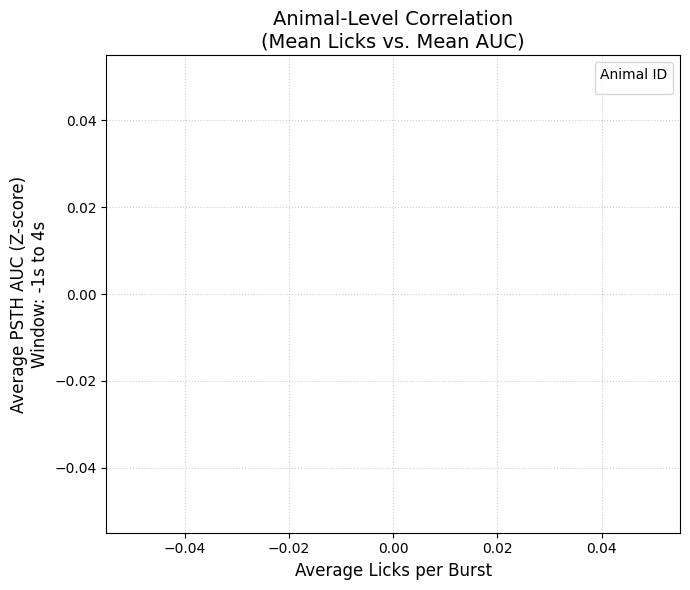


--- Summary Data ---


In [132]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import pearsonr, linregress

# =============================================================================
# Animal-Level Correlation: Mean Licks vs. Mean AUC
# =============================================================================

# Settings
AUC_WINDOW = (-1, 4)  # Window for AUC calculation (seconds)

# Containers for animal-level means
mean_licks_per_animal = []
mean_auc_per_animal = []
animal_ids_list = []

print(f"Computing per-animal averages for Correlation ({AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s)...")

for animal_id in sorted(psth_results.keys()):
    # 1. Retrieve Data
    psth_data = psth_results[animal_id]
    mat = psth_data["psth_matrix"]
    tvec = psth_data["time_vector"]

    # 2. Compute Mean AUC for this animal
    # Method: Calculate AUC for the *average trace* (more robust to noise)
    # Alternatively, you could calc AUC per trial then mean, but for Z-scores, linear operations are commutative.

    # Calculate Mean Trace first
    mean_trace = np.nanmean(mat, axis=0)

    # Estimate sampling rate
    fs = 1.0 / np.nanmedian(np.diff(tvec))

    # Find indices for integration
    idx_start = np.searchsorted(tvec, AUC_WINDOW[0])
    idx_end = np.searchsorted(tvec, AUC_WINDOW[1])

    # Compute AUC of the mean trace
    animal_auc = np.trapz(mean_trace[idx_start:idx_end], dx=1/fs)

    # 3. Compute Mean Licks for this animal
    # Retrieve raw burst sizes
    raw_burst_sizes = per_animal[animal_id]["burst_sizes"]

    # Filter for valid bursts only (same filter as PSTH events)
    raw_lick_onsets = per_animal[animal_id]["lick_onset"]
    valid_mask = ~np.isnan(raw_lick_onsets)
    valid_burst_sizes = raw_burst_sizes[valid_mask]

    # Calculate mean lick count
    if len(valid_burst_sizes) > 0:
        animal_mean_licks = np.mean(valid_burst_sizes)
    else:
        print(f"Warning: No valid bursts for {animal_id}")
        continue

    # 4. Store Data
    mean_licks_per_animal.append(animal_mean_licks)
    mean_auc_per_animal.append(animal_auc)
    animal_ids_list.append(animal_id)

# Convert to numpy arrays
x_vals = np.array(mean_licks_per_animal)
y_vals = np.array(mean_auc_per_animal)

# =============================================================================
# Plotting & Statistics
# =============================================================================

plt.figure(figsize=(7, 6))

if len(x_vals) > 1:
    # 1. Linear Regression
    slope, intercept, r_val, p_val, std_err = linregress(x_vals, y_vals)

    # 2. Plot Points
    # Use a distinct color/marker for each animal
    for i, aid in enumerate(animal_ids_list):
        plt.scatter(x_vals[i], y_vals[i], s=150, zorder=3, label=aid, edgecolor='k')
        # Annotate ID next to dot
        plt.text(x_vals[i], y_vals[i], f"  {aid}", verticalalignment='center', fontsize=9)

    # 3. Plot Fit Line
    x_range = np.array([x_vals.min() * 0.9, x_vals.max() * 1.1])
    plt.plot(x_range, slope * x_range + intercept, 'k--', alpha=0.5, zorder=2,
             label=f"Fit (r={r_val:.2f})")

    # 4. Stats Text
    stats_msg = f"Pearson r = {r_val:.3f}\np = {p_val:.3f}"
    plt.text(0.05, 0.95, stats_msg, transform=plt.gca().transAxes,
             fontsize=12, verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.9))

else:
    plt.scatter(x_vals, y_vals, s=100)
    print("Not enough points for regression.")

# Aesthetics
plt.title("Animal-Level Correlation\n(Mean Licks vs. Mean AUC)", fontsize=14)
plt.xlabel("Average Licks per Burst", fontsize=12)
plt.ylabel(f"Average PSTH AUC (Z-score)\nWindow: {AUC_WINDOW[0]}s to {AUC_WINDOW[1]}s", fontsize=12)
plt.grid(True, linestyle=':', alpha=0.6)
plt.legend(title="Animal ID")
plt.tight_layout()
plt.show()

# Print Data for verification
print("\n--- Summary Data ---")
for aid, licks, auc in zip(animal_ids_list, x_vals, y_vals):
    print(f"{aid}: {licks:.2f} licks/burst | {auc:.2f} AUC")


In [133]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# Aggregation and Plotting using Pre-Computed 'psth_results'
# =============================================================================

# Container for animal averages
animal_mean_traces = []
animal_ids_list = []
common_tvec = None

print("Aggregating pre-computed per-animal averages...")

# Ensure psth_results exists
if 'psth_results' not in locals():
    print("Error: 'psth_results' dictionary not found. Please run the PSTH computation script first.")
else:
    for animal_id, data in psth_results.items():
        # 1. Retrieve Pre-computed Mean Trace
        mean_trace = data.get("mean_trace")
        tvec = data.get("time_vector")

        if mean_trace is None or tvec is None:
            print(f"  Warning: Missing data for {animal_id}, skipping.")
            continue

        # 2. Check for length consistency
        # Initialize common_tvec with the first valid animal
        if common_tvec is None:
            common_tvec = tvec
            expected_length = len(tvec)

        # Ensure alignment (simple length check)
        if len(mean_trace) != expected_length:
            print(f"  Warning: Length mismatch for {animal_id} ({len(mean_trace)} vs {expected_length}). Skipping.")
            continue

        # 3. Store
        animal_mean_traces.append(mean_trace)
        animal_ids_list.append(animal_id)

    # --- Plotting ---

    if len(animal_mean_traces) > 0:
        # Stack into matrix: (n_animals x n_timepoints)
        grand_matrix = np.vstack(animal_mean_traces)
        n_animals = grand_matrix.shape[0]

        # Compute Grand Average and SEM across animals
        grand_mean = np.nanmean(grand_matrix, axis=0)
        grand_sem = np.nanstd(grand_matrix, axis=0) / np.sqrt(n_animals)

        print(f"Averaging across {n_animals} animals.")

        # Create figure with 2 subplots
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True, gridspec_kw={'height_ratios': [2, 1]})

        # --- Subplot 1: Heatmap (Each line is an animal) ---
        # Extent controls the axis values: [x_min, x_max, y_min, y_max]
        # We set y to range from -0.5 to n_animals-0.5 so ticks align with integers
        im = ax1.imshow(grand_matrix, aspect='auto', origin='lower',
                        extent=[common_tvec[0], common_tvec[-1], -0.5, n_animals - 0.5],
                        cmap='viridis', vmin=-2, vmax=2) # Adjust vmin/vmax for Z-score visibility

        ax1.set_yticks(range(n_animals))
        ax1.set_yticklabels(animal_ids_list)
        ax1.set_ylabel("Animal ID")
        ax1.set_title("Mean Response per Animal (Heatmap)")
        ax1.axvline(0, color='w', linestyle='--', alpha=0.7)
        plt.colorbar(im, ax=ax1, label="Z-score")

        # --- Subplot 2: Grand Average Trace ---
        # Plot individual animal traces (faint lines)
        for i in range(n_animals):
            ax2.plot(common_tvec, grand_matrix[i, :], color='gray', alpha=0.3, lw=1)

        # Plot Grand Mean + SEM
        ax2.plot(common_tvec, grand_mean, color='k', lw=2, label=f"Grand Mean (n={n_animals})")
        ax2.fill_between(common_tvec, grand_mean - grand_sem, grand_mean + grand_sem,
                        color='k', alpha=0.2, label="SEM")

        ax2.axvline(0, color='r', linestyle='--', alpha=0.7, label="2nd Lick Onset")
        ax2.set_xlabel("Time from Lick Onset (s)")
        ax2.set_ylabel("Z-score")
        ax2.set_title("Average PSTH Across Animals")
        ax2.set_xlim(common_tvec[0], common_tvec[-1])
        ax2.legend()

        plt.tight_layout()
        plt.show()
    else:
        print("No valid data to average.")


Aggregating pre-computed per-animal averages...
No valid data to average.
